### Init

In [6]:
from tsplearn import *
import numpy as np 
import pandas as pd

prob_T=0.5

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1] # N2
nd = B1.shape[1] # N1
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = B2@G.mask
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(M*sparsity) # Sparsity
sparsity_mode = "max"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

In [7]:
gen_params={'dictionary_type':dictionary_type,
        'm_train':m_train,
        'm_test':m_test,
        'P':P,
        'M':M,
        'J':J,
        'sparsity':sparsity,
        'K0_max':K0_max,
        'sparsity_mode':sparsity_mode,
        'n_search':n_search,
        'n_sim':n_sim,
        'prob_T':prob_T}

In [8]:
load_data = generate_data(Lu, Ld, **gen_params)

D_true = load_data['D_true']
Y_train = load_data['Y_train']
Y_test = load_data['Y_test']
X_train = load_data['X_train']
X_test = load_data['X_test']
epsilon_true =  load_data['epsilon_true']
c_true = load_data['c_true']

# Class

In [5]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.tsp_generation import *
from typing import Tuple, List, Union, Dict
import pickle
from functools import wraps
from einops import rearrange

from lib import * # SeparateHodgelet, SimplicianSlepians


def _indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)

def _indicator_matrix_rev(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 1
    return np.diag(tmp)

def _compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj

def _split_coeffs(h ,s ,k, sep=False):
    h_tmp = h.value.flatten()
    # hH = h_tmp[:s,].reshape((s,1))
    # hS = h_tmp[s:s*(k+1),].reshape((s,k))
    # hI = h_tmp[s*(k+1):,].reshape((s,k))
    if sep:
        hH = h_tmp[np.arange(0, (s*(2*k+1)), (2*k+1))].reshape((s,1))
        hS = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(2*k+1)), (2*k+1))])].reshape((s,k))
        hI = h_tmp[np.hstack([[i,i+1] for i in range((k+1), (s*(2*k+1)), (2*k+1))])].reshape((s,k))
        return [hH, hS, hI]
    hi = h_tmp[np.arange(0, (s*(k+1)), (k+1))].reshape((s,1))
    h = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(k+1)), (k+1))])].reshape((s,k))
    return np.hstack([h, hi])
    
def sparse_transform(D, K0, Y_te, Y_tr=None):

    ep = np.finfo(float).eps # to avoid some underflow problems
    dd = la.norm(D, axis=0) + ep
    W = np.diag(1. / dd)
    Domp = D @ W
    X_te = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_te)
    # Normalization
    X_te = W @ X_te

    if np.all(Y_tr == None):

        return X_te
    
    # Same for the training set
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_tr)
    X_tr = W @ X_tr
    
    return X_te, X_tr


def compute_vandermonde(L, k):
    
    def polynomial_exp(x, k):
        x = x** np.arange(0, k + 1)
        return x

    eigenvalues, _ = sla.eig(L)
    idx = eigenvalues.argsort()
    tmp_df = pd.DataFrame({'Eigs': eigenvalues[idx]})
    tmp_df['Poly'] = tmp_df['Eigs'].apply(lambda x:  polynomial_exp(x,k))
    B = np.vstack(tmp_df['Poly'].to_numpy())

    return B


def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)

class TspSolver:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
                'P': None,      # Number of Kernels (Sub-dictionaries)
                'J': None,      # Polynomial order
                'K0': None,     # Sparsity level
                'dictionary_type': None,
                'c': None,      # spectral control parameter 
                'epsilon': None,# spectral control parameter
                'n': 10,        # number of nodes
                'sub_size': None,   # Number of sub-sampled nodes
                'prob_T': 1.,   # Ratio of colored triangles
                'true_prob_T': 1.,   # True ratio of colored triangles
                'p_edges': 1.,  # Probability of edge existence
                'seed': None,       ####
                'option' : "One-shot-diffusion",        ####
                'diff_order_sol' : 1,       ####
                'diff_order_irr' : 1,       ####
                'step_prog' : 1,        ####
                'top_k_slepians' : 2        ####
                }
        
        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError("When using positional arguments, must provide a single dictionary")
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data
        self.G = EnhancedGraph(n=params['n'],
                               p_edges=params['p_edges'], 
                               p_triangles=params['prob_T'], 
                               seed=params['seed']) 
        # Incidence matrices
        self.B1: np.ndarray = self.G.get_b1()
        self.B2: np.ndarray = self.G.get_b2()

        # Sub-sampling if needed to decrease complexity
        if params['sub_size'] != None:
            self.B1 = self.B1[:, :params['sub_size']]
            self.B2 = self.B2[:params['sub_size'], :]
            self.B2 = self.B2[:,np.sum(np.abs(self.B2), 0) == 3]
        
        # Topology dimensions and hyperparameters
        self.nu: int = self.B2.shape[1]
        self.nd: int = self.B1.shape[1]
        self.true_prob_T = params['true_prob_T']
        self.T: int = int(np.ceil(self.nu*(1-params['prob_T'])))
        self.num_tri = 0

        # Laplacians according to the Hodge Theory for cell complexes
        Lu, Ld, L = self.G.get_laplacians(sub_size=params['sub_size'])
        self.Lu: np.ndarray = Lu                             # Ground-truth upper Laplacian
        self.Ld: np.ndarray = Ld                             # Ground-truth lower Laplacian
        self.L: np.ndarray = L                               # Ground-truth sum Laplacian
        self.Lu_full: np.ndarray = self.G.get_laplacians(sub_size=params['sub_size'], 
                                                    full=True)
        self.M =  L.shape[0]
        

        # Dictionary hyperparameters
        self.P = params['P']                                 # Number of sub-dicts
        self.J = params['J']                                 # Polynomial order for the Hodge Laplacian
        self.c = params['c']                                 # Hyperparameter for stability in frequency domain
        self.epsilon = params['epsilon']                     # Hyperparameter for stability in frequency domain
        self.K0 = params['K0']                               # Assumed sparsity level
        self.dictionary_type = params['dictionary_type']
        # Init optimal values for sparse representations and overcomplete dictionary
        self.D_opt: np.ndarray = np.zeros((self.M, self.M*self.P))
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)
        # Init the learning errors and error curve (history)
        self.min_error_train = 1e20
        self.min_error_test = 1e20
        self.history: List[np.ndarray] = []

        ############################################################################################################
        ##                                                                                                        ##
        ##               This section is only for learnable (data-driven) dictionaries                            ##
        ##                                                                                                        ##
        ############################################################################################################

        # Init the dictionary parameters according to the specific parameterization setup
        if self.dictionary_type=="separated":
            hs = np.zeros((self.P,self.J))
            hi = np.zeros((self.P,self.J))
            hh = np.zeros((self.P,1))
            self.h_opt: List[np.ndarray] = [hh,hs,hi]
        else:
            h = np.zeros((self.P, self.J))
            hi = np.zeros((self.P, 1))
            self.h_opt: List[np.ndarray] = [hi, h]

        # Compute the polynomial extension for the Laplacians and the auxiliary 
        # "pseudo-vandermonde" matrix for the constraints in the quadratic form
        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.L, self.J)
            self.B = compute_vandermonde(self.L, self.J).real
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.Ld, self.J)
            self.B = compute_vandermonde(self.Ld, self.J).real
        elif  self.dictionary_type == 'separated':
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, self.J, separated=True)
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(self.Ld, self.J, separated=True)
            self.Bu = compute_vandermonde(self.Lu, self.J).real
            self.Bd = compute_vandermonde(self.Ld, self.J)[:, 1:].real
            self.B = np.hstack([self.Bu, self.Bd])

        # Auxiliary matrix to define quadratic form dor the dictionary learning step
        self.P_aux: np.ndarray = None
        # Flag variable: the dictionary is learnable or analytic
        self.dict_is_learnable = self.dictionary_type in ["separated", "joint", "edge_laplacian"]

        # Auxiliary tools for the Slepians-based dictionary setup
        if self.dictionary_type == 'slepians':
            self.option = params['option']
            self.diff_order_sol = params['diff_order_sol']
            self.step_prog = params['step_prog']
            self.diff_order_irr = params['diff_order_irr']
            self.source_sol = np.ones((self.nd,))
            self.source_irr = np.ones((self.nd,))
            self.top_K_slepians = params['top_k_slepians']
            self.spars_level = list(range(10,80,10))
            # Remember that this part should be updated if B2 or Lu are updated!
            self.F_sol,self.F_irr = get_frequency_mask(self.B1,self.B2) # Get frequency bands
            self.S_neigh, self.complete_coverage = cluster_on_neigh(self.B1,
                                                                    self.B2,
                                                                    self.diff_order_sol,
                                                                    self.diff_order_irr,
                                                                    self.source_sol,
                                                                    self.source_irr,
                                                                    self.option,
                                                                    self.step_prog)
            self.R = [self.F_sol, self.F_irr]
            self.S = self.S_neigh

        # Auxiliary tools for the Wavelet-based dictionary setup
        elif self.dictionary_type == 'wavelet':
            # Remember that this part should be updated if B2 or Lu are updated!
            self.w1 = np.linalg.eigvalsh(self.Lu)
            self.w2 = np.linalg.eigvalsh(self.Ld)
            

    # def fit(self) -> Tuple[float, List[np.ndarray], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #     min_error_test, _, _, h_opt, X_opt_test, D_opt = self.learn_upper_laplacian()
    #     return min_error_test, self.history, params['Lu'], h_opt, X_opt_test, D_opt

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, 
                                                                                    self.J, 
                                                                                    separated=True)
        self.Bu = compute_vandermonde(self.Lu, self.J).real
        self.B = np.hstack([self.Bu, self.Bd])

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, P=P, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(self,
                  h_prior: np.ndarray = None, 
                  mode: str = "only_X") -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """
        
        # If no prior info on the dictionary
        if np.all(h_prior == None):

            # Init Dictionary
            if (mode in ["all","only_D"]):

                discard = 1
                while discard==1:

                    if self.dictionary_type != "separated":
                        h_prior, discard = self._multiplier_search(self.lambda_max_j, 
                                                              self.lambda_min_j, 
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Lj)

                    else:
                        h_prior, discard = self._multiplier_search(self.lambda_max_d_j, 
                                                              self.lambda_min_d_j, 
                                                              self.lambda_max_u_j, 
                                                              self.lambda_min_u_j,
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Luj, 
                                                         self.Ldj)

            # Init Sparse Representations
            if (mode in ["all","only_X"]):
                
                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1./dd)
                Dx = Dx / la.norm(Dx)  
                Domp = Dx@W
                X = np.apply_along_axis(lambda x: get_omp_coeff(self.K0, Domp.real, x), axis=0, arr=self.Y_train)
                X = np.tile(X, (self.P,1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize both the dictionary and the sparse representation
        else:
            
            self.h_opt = h_prior

            if self.dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Luj, 
                                                 self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)
            else: 
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)             

   
    def save_results(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):

            outputs = func(self, *args, **kwargs)
            func_name = func.__name__

            if func_name == "topological_dictionary_learn":

                path = os.getcwd()
                dir_path = os.path.join(path, 
                                        'results', 
                                        'dictionary_learning',
                                        f'{self.dictionary_type}')
                name = f'learn_D_{self.dictionary_type}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": outputs[2],
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}
                
            elif func_name == "learn_upper_laplacian":

                path = os.getcwd()
                dir_path = os.path.join(path, 'results', 'topology_learning')
                name = f'learn_T{int(self.true_prob_T*100)}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": self.history,
                            "Lu_opt": self.Lu,
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}

            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            try:
                with open(filename, 'wb') as file:
                    pickle.dump(save_var, file)
            except IOError as e:
                print(f"An error occurred while writing the file: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

            return outputs  
        return wrapper

    def topological_dictionary_learn(self,
                                     lambda_: float = 1e-3, 
                                     max_iter: int = 10, 
                                     patience: int = 10,
                                     tol: float = 1e-7,
                                     step_h: float = 1.,
                                     step_x: float = 1.,
                                     solver: str ="MOSEK", 
                                     verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        if self.dict_is_learnalbe:

            # Init the dictionary and the sparse representation 
            D_coll = [cp.Constant(self.D_opt[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))
            
            while pat_iter < patience and iter_ <= max_iter:
                
                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [cp.Constant(D[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))
                
                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    hI = cp.Variable((self.P, 1))
                    h.value, hI.value = h_opt
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += (cp.Constant(self.Lj[j, :, :]) * h[i,j])
                        tmp += (I*hI[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i]for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hH.value, hS.value, hI.value = h_opt ##################### OCCHIO
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += ((cp.Constant(self.Luj[j, :, :])*hS[i,j]) + (cp.Constant(self.Ldj[j, :, :])*hI[i,j]))
                        tmp += (I*hH[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
        
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                    term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = [D_coll[i] >> 0 for i in range(self.P)] + \
                                [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)] + \
                                [(Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0, (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Dictionary Update
                D = D.value
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = [h_opt[0] + step_h*(h.value - h_opt[0]),
                             h_opt[1] + step_h*(hI.value - h_opt[1])]
                else:
                    h_opt = [h_opt[0] + step_h*(hH.value-h_opt[0]),
                             h_opt[1] + step_h*(hS.value-h_opt[1]), 
                             h_opt[2] + step_h*(hI.value-h_opt[2])]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)

            # Error Updating
            self.min_error_train = nmse(self.D_opt, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(self.D_opt, self.X_opt_test, self.Y_test, self.m_test)
            
        return self.min_error_test, self.min_error_train, hist
    

    def _aux_matrix_update(self, X):

        I = [np.eye(self.M)]
        if self.dictionary_type=="separated":
            LLu = [lu for lu in self.Luj]
            LLd = [ld for ld in self.Ldj]
            LL = np.array(I+LLu+LLd)
        else:
            LL = [l for l in self.Lj]
            LL = np.array(I + LL)

        P_aux = np.array([LL@X[(i*self.M): ((i+1)*self.M), :] for i in range(self.P)])
        self.P_aux = rearrange(P_aux, 'b h w c -> (b h) w c')
    
    def topological_dictionary_learn_qp(self,
                                        lambda_: float = 1e-3, 
                                        max_iter: int = 10, 
                                        patience: int = 10,
                                        tol: float = 1e-7,
                                        solver: str = 'GUROBI',
                                        step_h: float = 1.,
                                        step_x: float = 1.,
                                        verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        
        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        # Learnable Dictionary -> ADMM optimization algorithm
        if self.dict_is_learnable:
            
            # Init the the sparse representation
            h_opt = np.hstack([h.flatten() for h in self.h_opt]).reshape(-1,1)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            f = 2 if self.dictionary_type == "separated" else 1
            reg = lambda_ * np.eye(self.P*(f*self.J+1))
            I_s = cp.Constant(np.eye(self.P))
            i_s = cp.Constant(np.ones((self.P,1)))
            B = cp.Constant(self.B)

            while pat_iter < patience and iter_ <= max_iter:

                # Init variables and parameters
                h = cp.Variable((self.P*(f*self.J+1), 1)) 
                self._aux_matrix_update(X_tr)
                h.value = h_opt

                Q = cp.Constant(np.einsum('imn, lmn -> il', self.P_aux, self.P_aux) + reg)
                l = cp.Constant(np.einsum('mn, imn -> i', self.Y_train, self.P_aux))

                # Quadratic term
                term2 = cp.quad_form(h, Q, assume_PSD = True)
                # Linear term
                term1 = l@h
                term1 = cp.multiply(-2, term1)[0]
                
                obj = cp.Minimize(term2+term1)

                # Define the constraints
                cons1 = cp.kron(I_s, B)@h
                cons2 = cp.kron(i_s.T, B)@h
                constraints = [cons1 >= 0] + \
                                [cons1 <= self.c] + \
                                [cons2 >= (self.c - self.epsilon)] + \
                                [cons2 <= (self.c + self.epsilon)]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Update the dictionary

                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_tmp = _split_coeffs(h, self.P, self.J)
                    # print(h_tmp.shape)
                    # h_tmp = h.value.reshape(self.P, self.J+1)
                    D = generate_dictionary(h_tmp, self.P, self.Lj)                      
                    h_opt = h_opt + step_h*(h.value - h_opt)
                else:

                    h_list = _split_coeffs(h, self.P, self.J, sep=True)
                    D = generate_dictionary(h_list, self.P, self.Luj, self.Ldj)                                
                    h_opt = h_opt + step_h*(h.value - h_opt)


                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_list if self.dictionary_type == 'separated' else h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        # Analytic Dictionary -> directly go to OMP step
        else:
            
            if self.dictionary_type == "fourier":
                # Fourier Dictionary Benchmark
                _, self.D_opt = sla.eigh(self.L)

            elif self.dictionary_type == "slepians":
                SS = SimplicianSlepians(self.B1, 
                                        self.B2, 
                                        self.S, 
                                        self.R,
                                        verbose=False, 
                                        top_K = self.top_K_slepians)
                self.D_opt = SS.atoms_flat
                

            elif self.dictionary_type == "wavelet":
                SH = SeparateHodgelet(self.B1, 
                                      self.B2,
                                      *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w1))),
                                      *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w2))))
                self.D_opt = SH.atoms_flat
                # print(self.D_opt.shape)
            
            # OMP
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)
            # Error Updating
            self.min_error_train = nmse(self.D_opt, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(self.D_opt, self.X_opt_test, self.Y_test, self.m_test)

        return self.min_error_test, self.min_error_train, hist
    
    @save_results
    def learn_upper_laplacian(self,
                              Lu_new: np.ndarray = None,
                              filter: np.ndarray = 1,
                              h_prior: np.ndarray = None,
                              lambda_: float = 1e-3, 
                              max_iter: int = 10, 
                              patience: int = 10,
                              tol: float = 1e-7,
                              step_h: float = 1.,
                              step_x: float = 1.,
                              mode: str = "optimistic",
                              verbose: bool = False,
                              warmup: int = 0,
                              QP=False,
                              cont=False):
    
        assert step_h<1 or step_h>0, "You must provide a step-size between 0 and 1."
        assert step_x<1 or step_x>0, "You must provide a step-size between 0 and 1."
        assert (mode=="optimistic") or (mode=="pessimistic"), f'{mode} is not a legal mode: \"optimistic\" or \"pessimistic\" are the only ones allowed.'
        
        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = self.B2.shape[1]
            if mode=="optimistic":
                filter = np.ones(T)
                self.warmup=0  
            else:
                filter = np.zeros(T)
                self.update_Lu(np.zeros(self.Lu.shape)) # start with an "empty" upper Laplacian
                self.warmup = warmup
        else:
            self.update_Lu(Lu_new)

        self.init_dict(h_prior=h_prior,
                       mode="only_X")

        if QP:
            _, _, hist = self.topological_dictionary_learn_qp(lambda_=lambda_,
                                                            max_iter=max_iter,
                                                            patience=patience,
                                                            tol=tol,
                                                            step_h=step_h,
                                                            step_x=step_x,
                                                            solver='GUROBI')
        else:
            _, _, hist = self.topological_dictionary_learn(lambda_=lambda_,
                                                            max_iter=max_iter,
                                                            patience=patience,
                                                            tol=tol,
                                                            step_h=step_h,
                                                            step_x=step_x)
                        
        self.history.append(hist)
        search_space = np.where(filter == 1) if mode=="optimistic" else np.where(filter == 0)   
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda _: filter)
        if mode=="optimistic":
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix(x), axis=1)
        else:
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix_rev(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: _compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1)
        sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, self.K0, self.Y_test))
        sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, self.Y_test, self.m_test), axis=1)
        
        if self.warmup>0:
            candidate_error = sigmas.NMSE.min() - np.finfo(float).eps
            self.warmup-=1
        else:
            candidate_error = sigmas.NMSE.min()
        idx_min = sigmas.NMSE.idxmin()

        
        if candidate_error < self.min_error_test:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)
            self.num_tri += 1
            if verbose:
                if mode=="optimistic":
                    print(f'Number of removed triangles: {self.num_tri} \n ... New min test error: {candidate_error} !')
                else:
                    print(f'Number of added triangles: {self.num_tri} \n ... New min test error: {candidate_error} !')

            return self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode=mode,
                                              verbose=verbose,
                                              QP=QP,
                                              cont=cont)
        
        # For the last recursions of "pessimistic" mode try some recursion of the "optimistic"
        # to remove the warm-up randomly-added triangles
        if mode == "pessimistic" and not cont:
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="optimistic",
                                              verbose=verbose,
                                              QP=QP,
                                              cont=True)
        
        # Then after we added triangles and removed the randomly added ones, continue adding!
        elif mode != "pessimistic" and cont:

            print("Ce provo!")
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="pessimistic",
                                              verbose=verbose,
                                              QP=QP,
                                              cont=cont,
                                              warmup=warmup)  
                  
        self.B2 = self.B2@np.diag(filter)
        return self.min_error_test, self.history, self.Lu, self.B2

# T80

In [9]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.tsp_generation import *
from typing import Tuple, List, Union, Dict
import pickle
from functools import wraps
from einops import rearrange

from lib import * # SeparateHodgelet, SimplicianSlepians


def _indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)

def _indicator_matrix_rev(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 1
    return np.diag(tmp)

def _compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj

def _split_coeffs(h ,s ,k, sep=False):
    h_tmp = h.value.flatten()
    # hH = h_tmp[:s,].reshape((s,1))
    # hS = h_tmp[s:s*(k+1),].reshape((s,k))
    # hI = h_tmp[s*(k+1):,].reshape((s,k))
    if sep:
        hH = h_tmp[np.arange(0, (s*(2*k+1)), (2*k+1))].reshape((s,1))
        hS = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(2*k+1)), (2*k+1))])].reshape((s,k))
        hI = h_tmp[np.hstack([[i,i+1] for i in range((k+1), (s*(2*k+1)), (2*k+1))])].reshape((s,k))
        return [hH, hS, hI]
    hi = h_tmp[np.arange(0, (s*(k+1)), (k+1))].reshape((s,1))
    h = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(k+1)), (k+1))])].reshape((s,k))
    return np.hstack([h, hi])
    
def sparse_transform(D, K0, Y_te, Y_tr=None):

    ep = np.finfo(float).eps # to avoid some underflow problems
    dd = la.norm(D, axis=0) + ep
    W = np.diag(1. / dd)
    Domp = D @ W
    X_te = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_te)
    # Normalization
    X_te = W @ X_te

    if np.all(Y_tr == None):

        return X_te
    
    # Same for the training set
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_tr)
    X_tr = W @ X_tr
    
    return X_te, X_tr


def compute_vandermonde(L, k):
    
    def polynomial_exp(x, k):
        x = x** np.arange(0, k + 1)
        return x

    eigenvalues, _ = sla.eig(L)
    idx = eigenvalues.argsort()
    tmp_df = pd.DataFrame({'Eigs': eigenvalues[idx]})
    tmp_df['Poly'] = tmp_df['Eigs'].apply(lambda x:  polynomial_exp(x,k))
    B = np.vstack(tmp_df['Poly'].to_numpy())

    return B


def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)


class TspSolver:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
                'P': None,      # Number of Kernels (Sub-dictionaries)
                'J': None,      # Polynomial order
                'K0': None,     # Sparsity level
                'dictionary_type': None,
                'c': None,      # spectral control parameter 
                'epsilon': None,# spectral control parameter
                'n': 10,        # number of nodes
                'sub_size': None,   # Number of sub-sampled nodes
                'prob_T': 1.,   # Ratio of colored triangles
                'true_prob_T': 1.,   # True ratio of colored triangles
                'p_edges': 1.,  # Probability of edge existence
                'seed': None,       ####
                'option' : "One-shot-diffusion",        ####
                'diff_order_sol' : 1,       ####
                'diff_order_irr' : 1,       ####
                'step_prog' : 1,        ####
                'top_k_slepians' : 2        ####
                }
        
        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError("When using positional arguments, must provide a single dictionary")
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data
        self.G = EnhancedGraph(n=params['n'],
                               p_edges=params['p_edges'], 
                               p_triangles=params['prob_T'], 
                               seed=params['seed']) 
        # Incidence matrices
        self.B1: np.ndarray = self.G.get_b1()
        self.B2: np.ndarray = self.G.get_b2()

        # Sub-sampling if needed to decrease complexity
        if params['sub_size'] != None:
            self.B1 = self.B1[:, :params['sub_size']]
            self.B2 = self.B2[:params['sub_size'], :]
            self.B2 = self.B2[:,np.sum(np.abs(self.B2), 0) == 3]
        
        # Topology dimensions and hyperparameters
        self.nu: int = self.B2.shape[1]
        self.nd: int = self.B1.shape[1]
        self.true_prob_T = params['true_prob_T']
        self.T: int = int(np.ceil(self.nu*(1-params['prob_T'])))

        # Laplacians according to the Hodge Theory for cell complexes
        Lu, Ld, L = self.G.get_laplacians(sub_size=params['sub_size'])
        self.Lu: np.ndarray = Lu                             # Ground-truth upper Laplacian
        self.Ld: np.ndarray = Ld                             # Ground-truth lower Laplacian
        self.L: np.ndarray = L                               # Ground-truth sum Laplacian
        self.Lu_full: np.ndarray = G.get_laplacians(sub_size=params['sub_size'], 
                                                    full=True)
        self.M =  L.shape[0]
        

        # Dictionary hyperparameters
        self.P = params['P']                                 # Number of sub-dicts
        self.J = params['J']                                 # Polynomial order for the Hodge Laplacian
        self.c = params['c']                                 # Hyperparameter for stability in frequency domain
        self.epsilon = params['epsilon']                     # Hyperparameter for stability in frequency domain
        self.K0 = params['K0']                               # Assumed sparsity level
        self.dictionary_type = params['dictionary_type']
        # Init optimal values for sparse representations and overcomplete dictionary
        self.D_opt: np.ndarray = np.zeros((self.M, self.M*self.P))
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)
        # Init the learning errors and error curve (history)
        self.min_error_train = 1e20
        self.min_error_test = 1e20
        self.history: List[np.ndarray] = []

        ############################################################################################################
        ##                                                                                                        ##
        ##               This section is only for learnable (data-driven) dictionaries                            ##
        ##                                                                                                        ##
        ############################################################################################################

        # Init the dictionary parameters according to the specific parameterization setup
        if self.dictionary_type=="separated":
            hs = np.zeros((self.P,self.J))
            hi = np.zeros((self.P,self.J))
            hh = np.zeros((self.P,1))
            self.h_opt: List[np.ndarray] = [hh,hs,hi]
        else:
            h = np.zeros((self.P, self.J))
            hi = np.zeros((self.P, 1))
            self.h_opt: List[np.ndarray] = [hi, h]

        # Compute the polynomial extension for the Laplacians and the auxiliary 
        # "pseudo-vandermonde" matrix for the constraints in the quadratic form
        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.L, self.J)
            self.B = compute_vandermonde(self.L, self.J).real
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.Ld, self.J)
            self.B = compute_vandermonde(self.Ld, self.J).real
        elif  self.dictionary_type == 'separated':
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, self.J, separated=True)
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(self.Ld, self.J, separated=True)
            self.Bu = compute_vandermonde(self.Lu, self.J).real
            self.Bd = compute_vandermonde(self.Ld, self.J)[:, 1:].real
            self.B = np.hstack([self.Bu, self.Bd])

        # Auxiliary matrix to define quadratic form dor the dictionary learning step
        self.P_aux: np.ndarray = None
        # Flag variable: the dictionary is learnable or analytic
        self.dict_is_learnable = self.dictionary_type in ["separated", "joint", "edge_laplacian"]

        # Auxiliary tools for the Slepians-based dictionary setup
        if self.dictionary_type == 'slepians':
            self.option = params['option']
            self.diff_order_sol = params['diff_order_sol']
            self.step_prog = params['step_prog']
            self.diff_order_irr = params['diff_order_irr']
            self.source_sol = np.ones((self.nd,))
            self.source_irr = np.ones((self.nd,))
            self.top_K_slepians = params['top_k_slepians']
            self.spars_level = list(range(10,80,10))
            # Remember that this part should be updated if B2 or Lu are updated!
            self.F_sol,self.F_irr = get_frequency_mask(self.B1,self.B2) # Get frequency bands
            self.S_neigh, self.complete_coverage = cluster_on_neigh(self.B1,
                                                                    self.B2,
                                                                    self.diff_order_sol,
                                                                    self.diff_order_irr,
                                                                    self.source_sol,
                                                                    self.source_irr,
                                                                    self.option,
                                                                    self.step_prog)
            self.R = [self.F_sol, self.F_irr]
            self.S = self.S_neigh

        # Auxiliary tools for the Wavelet-based dictionary setup
        elif self.dictionary_type == 'wavelet':
            # Remember that this part should be updated if B2 or Lu are updated!
            self.w1 = np.linalg.eigvalsh(self.Lu)
            self.w2 = np.linalg.eigvalsh(self.Ld)
            

    # def fit(self) -> Tuple[float, List[np.ndarray], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #     min_error_test, _, _, h_opt, X_opt_test, D_opt = self.learn_upper_laplacian()
    #     return min_error_test, self.history, params['Lu'], h_opt, X_opt_test, D_opt

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, 
                                                                                    self.J, 
                                                                                    separated=True)
        self.Bu = compute_vandermonde(self.Lu, self.J).real
        self.B = np.hstack([self.Bu, self.Bd])

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, P=P, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(self,
                  h_prior: np.ndarray = None, 
                  mode: str = "only_X") -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """
        
        # If no prior info on the dictionary
        if np.all(h_prior == None):

            # Init Dictionary
            if (mode in ["all","only_D"]):

                discard = 1
                while discard==1:

                    if self.dictionary_type != "separated":
                        h_prior, discard = self._multiplier_search(self.lambda_max_j, 
                                                              self.lambda_min_j, 
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Lj)

                    else:
                        h_prior, discard = self._multiplier_search(self.lambda_max_d_j, 
                                                              self.lambda_min_d_j, 
                                                              self.lambda_max_u_j, 
                                                              self.lambda_min_u_j,
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Luj, 
                                                         self.Ldj)

            # Init Sparse Representations
            if (mode in ["all","only_X"]):
                
                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1./dd)
                Dx = Dx / la.norm(Dx)  
                Domp = Dx@W
                X = np.apply_along_axis(lambda x: get_omp_coeff(self.K0, Domp.real, x), axis=0, arr=self.Y_train)
                X = np.tile(X, (self.P,1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize both the dictionary and the sparse representation
        else:
            
            self.h_opt = h_prior

            if self.dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Luj, 
                                                 self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)
            else: 
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)             

   
    def save_results(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):

            outputs = func(self, *args, **kwargs)
            func_name = func.__name__

            if func_name == "topological_dictionary_learn":

                path = os.getcwd()
                dir_path = os.path.join(path, 
                                        'results', 
                                        'dictionary_learning',
                                        f'{self.dictionary_type}')
                name = f'learn_D_{self.dictionary_type}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": outputs[2],
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}
                
            elif func_name == "learn_upper_laplacian":

                path = os.getcwd()
                dir_path = os.path.join(path, 'results', 'topology_learning')
                name = f'learn_T{int(self.true_prob_T*100)}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": self.history,
                            "Lu_opt": self.Lu,
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}

            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            try:
                with open(filename, 'wb') as file:
                    pickle.dump(save_var, file)
            except IOError as e:
                print(f"An error occurred while writing the file: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

            return outputs  
        return wrapper

    def topological_dictionary_learn(self,
                                     lambda_: float = 1e-3, 
                                     max_iter: int = 10, 
                                     patience: int = 10,
                                     tol: float = 1e-7,
                                     step_h: float = 1.,
                                     step_x: float = 1.,
                                     solver: str ="MOSEK", 
                                     verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        if self.dict_is_learnalbe:

            # Init the dictionary and the sparse representation 
            D_coll = [cp.Constant(self.D_opt[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))
            
            while pat_iter < patience and iter_ <= max_iter:
                
                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [cp.Constant(D[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))
                
                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    hI = cp.Variable((self.P, 1))
                    h.value, hI.value = h_opt
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += (cp.Constant(self.Lj[j, :, :]) * h[i,j])
                        tmp += (I*hI[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i]for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hH.value, hS.value, hI.value = h_opt ##################### OCCHIO
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += ((cp.Constant(self.Luj[j, :, :])*hS[i,j]) + (cp.Constant(self.Ldj[j, :, :])*hI[i,j]))
                        tmp += (I*hH[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
        
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                    term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = [D_coll[i] >> 0 for i in range(self.P)] + \
                                [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)] + \
                                [(Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0, (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Dictionary Update
                D = D.value
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = [h_opt[0] + step_h*(h.value - h_opt[0]),
                             h_opt[1] + step_h*(hI.value - h_opt[1])]
                else:
                    h_opt = [h_opt[0] + step_h*(hH.value-h_opt[0]),
                             h_opt[1] + step_h*(hS.value-h_opt[1]), 
                             h_opt[2] + step_h*(hI.value-h_opt[2])]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)

            # Error Updating
            self.min_error_train = nmse(self.D_opt, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(self.D_opt, self.X_opt_test, self.Y_test, self.m_test)
            
        return self.min_error_test, self.min_error_train, hist
    

    def _aux_matrix_update(self, X):

        I = [np.eye(self.M)]
        if self.dictionary_type=="separated":
            LLu = [lu for lu in self.Luj]
            LLd = [ld for ld in self.Ldj]
            LL = np.array(I+LLu+LLd)
        else:
            LL = [l for l in self.Lj]
            LL = np.array(I + LL)

        P_aux = np.array([LL@X[(i*self.M): ((i+1)*self.M), :] for i in range(self.P)])
        self.P_aux = rearrange(P_aux, 'b h w c -> (b h) w c')
    
    def topological_dictionary_learn_qp(self,
                                        lambda_: float = 1e-3, 
                                        max_iter: int = 10, 
                                        patience: int = 10,
                                        tol: float = 1e-7,
                                        solver: str = 'GUROBI',
                                        step_h: float = 1.,
                                        step_x: float = 1.,
                                        verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        
        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        # Learnable Dictionary -> ADMM optimization algorithm
        if self.dict_is_learnable:
            
            # Init the the sparse representation
            h_opt = np.hstack([h.flatten() for h in self.h_opt]).reshape(-1,1)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            f = 2 if self.dictionary_type == "separated" else 1
            reg = lambda_ * np.eye(self.P*(f*self.J+1))
            I_s = cp.Constant(np.eye(self.P))
            i_s = cp.Constant(np.ones((self.P,1)))
            B = cp.Constant(self.B)

            while pat_iter < patience and iter_ <= max_iter:

                # Init variables and parameters
                h = cp.Variable((self.P*(f*self.J+1), 1)) 
                self._aux_matrix_update(X_tr)
                h.value = h_opt

                Q = cp.Constant(np.einsum('imn, lmn -> il', self.P_aux, self.P_aux) + reg)
                l = cp.Constant(np.einsum('mn, imn -> i', self.Y_train, self.P_aux))

                # Quadratic term
                term2 = cp.quad_form(h, Q, assume_PSD = True)
                # Linear term
                term1 = l@h
                term1 = cp.multiply(-2, term1)[0]
                
                obj = cp.Minimize(term2+term1)

                # Define the constraints
                cons1 = cp.kron(I_s, B)@h
                cons2 = cp.kron(i_s.T, B)@h
                constraints = [cons1 >= 0] + \
                                [cons1 <= self.c] + \
                                [cons2 >= (self.c - self.epsilon)] + \
                                [cons2 <= (self.c + self.epsilon)]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Update the dictionary

                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_tmp = _split_coeffs(h, self.P, self.J)
                    # print(h_tmp.shape)
                    # h_tmp = h.value.reshape(self.P, self.J+1)
                    D = generate_dictionary(h_tmp, self.P, self.Lj)                      
                    h_opt = h_opt + step_h*(h.value - h_opt)
                else:

                    h_list = _split_coeffs(h, self.P, self.J, sep=True)
                    D = generate_dictionary(h_list, self.P, self.Luj, self.Ldj)                                
                    h_opt = h_opt + step_h*(h.value - h_opt)


                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_list if self.dictionary_type == 'separated' else h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        # Analytic Dictionary -> directly go to OMP step
        else:
            
            if self.dictionary_type == "fourier":
                # Fourier Dictionary Benchmark
                _, self.D_opt = sla.eigh(self.L)

            elif self.dictionary_type == "slepians":
                SS = SimplicianSlepians(self.B1, 
                                        self.B2, 
                                        self.S, 
                                        self.R,
                                        verbose=False, 
                                        top_K = self.top_K_slepians)
                self.D_opt = SS.atoms_flat
                

            elif self.dictionary_type == "wavelet":
                SH = SeparateHodgelet(self.B1, 
                                      self.B2,
                                      *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w1))),
                                      *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w2))))
                self.D_opt = SH.atoms_flat
                # print(self.D_opt.shape)
            
            # OMP
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)
            # Error Updating
            self.min_error_train = nmse(self.D_opt, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(self.D_opt, self.X_opt_test, self.Y_test, self.m_test)

        return self.min_error_test, self.min_error_train, hist
    
    @save_results
    def learn_upper_laplacian(self,
                              Lu_new: np.ndarray = None,
                              filter: np.ndarray = 1,
                              h_prior: np.ndarray = None,
                              lambda_: float = 1e-3, 
                              max_iter: int = 10, 
                              patience: int = 10,
                              tol: float = 1e-7,
                              step_h: float = 1.,
                              step_x: float = 1.,
                              mode: str = "optimistic",
                              verbose: bool = False,
                              warmup: int = 0,
                              QP=False,
                              cont=False):
    
        assert step_h<1 or step_h>0, "You must provide a step-size between 0 and 1."
        assert step_x<1 or step_x>0, "You must provide a step-size between 0 and 1."
        assert (mode=="optimistic") or (mode=="pessimistic"), f'{mode} is not a legal mode: \"optimistic\" or \"pessimistic\" are the only ones allowed.'
        
        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = self.B2.shape[1]
            if mode=="optimistic":
                filter = np.ones(T)
                self.warmup=0  
            else:
                filter = np.zeros(T)
                self.update_Lu(np.zeros(self.Lu.shape)) # start with an "empty" upper Laplacian
                self.warmup = warmup
        else:
            self.update_Lu(Lu_new)

        self.init_dict(h_prior=h_prior,
                       mode="only_X")

        if QP:
            _, _, hist = self.topological_dictionary_learn_qp(lambda_=lambda_,
                                                            max_iter=max_iter,
                                                            patience=patience,
                                                            tol=tol,
                                                            step_h=step_h,
                                                            step_x=step_x,
                                                            solver='GUROBI')
        else:
            _, _, hist = self.topological_dictionary_learn(lambda_=lambda_,
                                                            max_iter=max_iter,
                                                            patience=patience,
                                                            tol=tol,
                                                            step_h=step_h,
                                                            step_x=step_x)
                        
        self.history.append(hist)
        search_space = np.where(filter == 1) if mode=="optimistic" else np.where(filter == 0)   
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda _: filter)
        if mode=="optimistic":
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix(x), axis=1)
        else:
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix_rev(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: _compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1)
        sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, self.K0, self.Y_test))
        sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, self.Y_test, self.m_test), axis=1)
        
        if self.warmup>0:
            candidate_error = sigmas.NMSE.min() - np.finfo(float).eps
            self.warmup-=1
        else:
            candidate_error = sigmas.NMSE.min()
        idx_min = sigmas.NMSE.idxmin()

        
        if candidate_error < self.min_error_test:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)

            if verbose:
                if mode=="optimistic":
                    print(f'Removing 1 triangle from topology... \n ... New min test error: {candidate_error} !')
                else:
                    print(f'Adding 1 triangle to topology... \n ... New min test error: {candidate_error} !')

            return self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode=mode,
                                              verbose=verbose,
                                              QP=QP,
                                              cont=cont)
        
        # For the last recursions of "pessimistic" mode try some recursion of the "optimistic"
        # to remove the warm-up randomly-added triangles
        if mode == "pessimistic" and not cont:
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="optimistic",
                                              verbose=verbose,
                                              QP=QP,
                                              cont=True)
        
        # Then after we added triangles and removed the randomly added ones, continue adding!
        elif mode != "pessimistic" and cont:

            print("Ce provo!")
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="pessimistic",
                                              verbose=verbose,
                                              QP=QP,
                                              cont=cont,
                                              warmup=warmup)  
                  
        self.B2 = self.B2@np.diag(filter)
        return self.min_error_test, self.history, self.Lu, self.B2




In [207]:
topoX2 = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

In [144]:
step_x = 1.
step_h = 1.

In [208]:
e1, e2, hist = topoX2.topological_dictionary_learn_qp(lambda_=lambda_,
                                        max_iter=max_iter,
                                        patience=patience,
                                        tol=tol,
                                        step_h=step_h,
                                        step_x=step_x,
                                        solver='GUROBI')

In [209]:
e1

0.023291742771661517

In [153]:
P*(J+1)

9

In [36]:
def simulate_top_learning(X_train, 
                            X_test,
                            Y_train,
                            Y_test, 
                            c_true, 
                            epsilon_true, 
                            n_sim, 
                            topo_params, 
                            K0_coll,
                            max_iter,
                            patience,
                            tol,
                            step_h: int = 1,
                            step_x: int = 1,
                            verbose: bool = True,
                            include_sdp: bool = True):


    min_error_qp_test = np.zeros((n_sim, len(K0_coll)))
    min_error_qp_comp_test = np.zeros((n_sim, len(K0_coll)))

    algo_errors = {
        "qp": min_error_qp_test,
        "qp_comp": min_error_qp_comp_test,
        }
    
    algo_types = {
        "qp": ("QP",True,False),
        "qp_comp": ("QP complete",True,True)
        }

    if include_sdp:
        min_error_sdp_test = np.zeros((n_sim, len(K0_coll)))
        algo_errors["sdp"] = min_error_sdp_test
        algo_types["sdp"] = ("SDP",False,False)
        # min_error_sdp_comp_test = np.zeros((n_sim, len(K0_coll)))
        # algo_errors["sdp_comp"] = min_error_sdp_comp_test
        # algo_types["sdp_comp"] = ("SDP complete",False,True)

    for sim in range(n_sim):

        for k0_index, k0 in tqdm(enumerate(K0_coll)):

            for a in algo_types.items():

                model = TspSolver(X_train=X_train[:, :, sim], 
                                    X_test=X_test[:, :, sim], 
                                    Y_train=Y_train[:, :, sim], 
                                    Y_test=Y_test[:, :, sim],
                                    c=c_true[sim],
                                    epsilon=epsilon_true[sim],
                                    K0=k0,
                                    dictionary_type="separated",
                                    **topo_params)

                try:
                    # Complete learning
                    if a[1][2]:
                        algo_errors[a[0]][sim,k0_index],  _, _, _ = model.learn_upper_laplacian(lambda_=lambda_, 
                                                                                                max_iter=max_iter,
                                                                                                patience=patience, 
                                                                                                tol=tol,
                                                                                                verbose=False,
                                                                                                step_h=step_h,
                                                                                                step_x=step_x,
                                                                                                QP=a[1][1])
                    # Learn only the dictionary (no topology)
                    else:
                        if a[1][1]:
                            algo_errors[a[0]][sim,k0_index], _, _ = model.topological_dictionary_learn(lambda_=lambda_, 
                                                                                                        max_iter=max_iter,
                                                                                                        patience=patience, 
                                                                                                        tol=tol,
                                                                                                        step_h=step_h,
                                                                                                        step_x=step_x)
                        else:
                            algo_errors[a[0]][sim,k0_index], _, _ = model.topological_dictionary_learn_qp(lambda_=lambda_, 
                                                                                                        max_iter=max_iter,
                                                                                                        patience=patience, 
                                                                                                        tol=tol,
                                                                                                        step_h=step_h,
                                                                                                        step_x=step_x)

                    if verbose:
                        print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} learning with {a[1][0]}... Done! Test Error: {algo_errors[a[0]][sim,k0_index]}")
                except:
                    print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {a[1][0]}... Diverged!')
                    # If diverged, simply interpolate
                    try:
                        algo_errors[a[0]][sim,k0_index] = algo_errors[a[0]][sim-1,k0_index]
                    except:
                        algo_errors[a[0]][sim,k0_index] = algo_errors[a[0]][sim-1,k0_index]

    return algo_errors

0.020213589758395246

### Slepians + Wave + Fourier + Edege Laplacian + Separated QP + Separated QP complete

In [6]:
topo_params2 = {"J":J,
                "P":P,
                "true_prob_T":prob_T,
                "sub_size":100,
                "seed":0,
                "n":40,
                "p_edges":0.162
                }

In [12]:
import warnings
warnings.filterwarnings("ignore")

min_error_slep_test = np.zeros((n_sim, len(K0_coll)))
min_error_wave_test = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))

algo_errors = {
    "slep": min_error_slep_test,
    "wave": min_error_wave_test,
    "fou": min_error_fou_test,
    "edge": min_error_edge_test
    }

algo_types = {
    "slep": ("slepians", "Slepians", False),
    "wave": ("wavelet", "Wavelets", False),
    "fou": ("fourier", "Fourier", False),
    "edge": ("edge_laplacian", "Edge Laplacian", False)
    }

for sim in range(n_sim):

    for k0_index, k0 in tqdm(enumerate(K0_coll)):

        for a in algo_types.items():

            model = TspSolver(X_train=X_train[:, :, sim], 
                                X_test=X_test[:, :, sim], 
                                Y_train=Y_train[:, :, sim], 
                                Y_test=Y_test[:, :, sim],
                                c=c_true[sim],
                                epsilon=epsilon_true[sim],
                                K0=k0,
                                dictionary_type=a[1][0],
                                **topo_params2)
            
            if a[1][2]:
                pass
            
            else:
                algo_errors[a[0]][sim,k0_index], _, _ = model.topological_dictionary_learn_qp(lambda_=lambda_, 
                                                                                            max_iter=max_iter,
                                                                                            patience=patience, 
                                                                                            tol=tol,
                                                                                            step_h=1,
                                                                                            step_x=1)

            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} learning with {a[1][1]}... Done! Test Error: {algo_errors[a[0]][sim,k0_index]}")
            
            # except:
            #     print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {a[1][0]}... Diverged!')
            #     # If diverged, simply interpolate
            #     try:
            #         algo_errors[a[0]][sim,k0_index] = algo_errors[a[0]][sim-1,k0_index]
            #     except:
            #         algo_errors[a[0]][sim,k0_index] = algo_errors[a[0]][sim-1,k0_index]

0it [00:00, ?it/s]

Simulation: 1/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.1675376933923439
Simulation: 1/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1069475075823744
Simulation: 1/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.28708937627490827


1it [00:11, 11.98s/it]

Simulation: 1/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.1411408187294678
Simulation: 1/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08019637904172106
Simulation: 1/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04666810427310101
Simulation: 1/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.16622603274100556


2it [00:47, 25.71s/it]

Simulation: 1/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.06600870944813829
Simulation: 1/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.047451161633115205
Simulation: 1/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.0242150515148052
Simulation: 1/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.10528722958128323


3it [01:39, 37.67s/it]

Simulation: 1/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.040515810999913617
Simulation: 1/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.030103481571398895
Simulation: 1/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.014401794758336346
Simulation: 1/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.06929246186461695


4it [02:24, 40.67s/it]

Simulation: 1/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.02789526126460969
Simulation: 1/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.019926506227145892
Simulation: 1/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.009631193319034776
Simulation: 1/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.04780386541584564


5it [03:45, 55.13s/it]

Simulation: 1/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.016444478308956102
Simulation: 1/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.014159442655562876
Simulation: 1/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.006862185399523474
Simulation: 1/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.03494004091975477


6it [05:05, 50.98s/it]


Simulation: 1/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.014073372219494075


0it [00:00, ?it/s]

Simulation: 2/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.1825991423364524
Simulation: 2/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.10843181738822483
Simulation: 2/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.29139250904238184


1it [00:13, 13.60s/it]

Simulation: 2/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.16539477913446599
Simulation: 2/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08610475144363512
Simulation: 2/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04194747826475868
Simulation: 2/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.16550506974637286


2it [00:51, 27.76s/it]

Simulation: 2/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.07937193838039613
Simulation: 2/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.04962095088610866
Simulation: 2/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.02127796999789187
Simulation: 2/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.10468163362060723


3it [01:40, 37.50s/it]

Simulation: 2/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.050114550368773526
Simulation: 2/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.030486666736825232
Simulation: 2/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.011970062839761545
Simulation: 2/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.07055612864672474


4it [03:04, 55.77s/it]

Simulation: 2/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.03234034220470799
Simulation: 2/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.019199852026459085
Simulation: 2/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.00714455537051323
Simulation: 2/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.04849458420052512


5it [04:42, 71.18s/it]

Simulation: 2/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.025674288285462657
Simulation: 2/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.013262306500518725
Simulation: 2/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.004655411332811838
Simulation: 2/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.03398706322359796


6it [05:37, 56.22s/it]


Simulation: 2/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.04317208036790731


0it [00:00, ?it/s]

Simulation: 3/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.19314994832192645
Simulation: 3/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1156935697807239
Simulation: 3/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.2879283900004655


1it [00:13, 13.66s/it]

Simulation: 3/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.1518540190643247
Simulation: 3/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.09302573564709543
Simulation: 3/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04961340954368386
Simulation: 3/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.16652367740708873


2it [00:41, 21.73s/it]

Simulation: 3/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.08347085471607397
Simulation: 3/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.053596375494113474
Simulation: 3/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.024612032505684348
Simulation: 3/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.10430995986527294


3it [01:43, 40.43s/it]

Simulation: 3/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04748098288072124
Simulation: 3/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.033247281412706636
Simulation: 3/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.014225893708999342
Simulation: 3/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.07057350026782101


4it [03:05, 56.66s/it]

Simulation: 3/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.030536607362913637
Simulation: 3/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.021496490181898465
Simulation: 3/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.009015969940559235
Simulation: 3/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.05005828402748658


5it [04:37, 69.57s/it]

Simulation: 3/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.023555275341192672
Simulation: 3/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.014751649592021
Simulation: 3/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.006079479187915789
Simulation: 3/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.035339452883015314


6it [06:27, 64.52s/it]


Simulation: 3/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.01683276572521799


0it [00:00, ?it/s]

Simulation: 4/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.18639150251368802
Simulation: 4/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.11522949133756558
Simulation: 4/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3068563053004578


1it [00:18, 18.43s/it]

Simulation: 4/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.1794513485757801
Simulation: 4/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.09237178395993616
Simulation: 4/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04764832806828684
Simulation: 4/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.18411688170246615


2it [00:50, 26.67s/it]

Simulation: 4/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.09333309027858046
Simulation: 4/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.05280620304740224
Simulation: 4/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.023352459667708388
Simulation: 4/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.11742241472847342


3it [01:37, 35.57s/it]

Simulation: 4/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.05753993127120547
Simulation: 4/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.03272327930616986
Simulation: 4/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.013132045548939375
Simulation: 4/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.07892661432705723


4it [02:39, 46.09s/it]

Simulation: 4/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.04014854078441036
Simulation: 4/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.021223482643665637
Simulation: 4/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.007904065052395668
Simulation: 4/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.054365415911158135


5it [03:55, 56.88s/it]

Simulation: 4/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.02694186904873354
Simulation: 4/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.014798107446594122
Simulation: 4/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.005022674264261901
Simulation: 4/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.03759703017532326


6it [04:15, 42.57s/it]


Simulation: 4/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.05700689959078127


0it [00:00, ?it/s]

Simulation: 5/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.18170209995944317
Simulation: 5/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1052082400392602
Simulation: 5/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.29899233731568126


1it [00:14, 14.95s/it]

Simulation: 5/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.16967544593406733
Simulation: 5/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08553686582539777
Simulation: 5/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04362415653125184
Simulation: 5/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.16606449480460414


2it [00:43, 23.15s/it]

Simulation: 5/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.08043795343767689
Simulation: 5/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.04812318485257515
Simulation: 5/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.021869499159494404
Simulation: 5/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.102686222962708


3it [01:44, 40.40s/it]

Simulation: 5/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04265184046458769
Simulation: 5/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.029277151569514194
Simulation: 5/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.011888187151730331
Simulation: 5/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.0645567379965674


4it [03:10, 58.17s/it]

Simulation: 5/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.029104736868891923
Simulation: 5/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.01892194187378687
Simulation: 5/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.006749583028861423
Simulation: 5/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.04448895954724952


5it [04:29, 65.71s/it]

Simulation: 5/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.02194109410779286
Simulation: 5/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.01297338641560354
Simulation: 5/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.004020567528867697
Simulation: 5/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.0322021820229636


6it [06:15, 62.54s/it]


Simulation: 5/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.015717715562565317


0it [00:00, ?it/s]

Simulation: 6/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.18740843176644612
Simulation: 6/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.11455202514632955
Simulation: 6/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3009730604454781


1it [00:13, 13.69s/it]

Simulation: 6/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.15855846005742769
Simulation: 6/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08991082520494086
Simulation: 6/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04738556894811587
Simulation: 6/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.17335477350173184


2it [00:42, 22.30s/it]

Simulation: 6/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.08669372478625936
Simulation: 6/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.05005247922225606
Simulation: 6/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.024093738915367376
Simulation: 6/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.10799646436288764


3it [01:39, 38.32s/it]

Simulation: 6/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.05261403643725598
Simulation: 6/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.03205966959419745
Simulation: 6/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.01343349265843791
Simulation: 6/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.06798049644061942


4it [02:54, 52.83s/it]

Simulation: 6/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.03577295741162253
Simulation: 6/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.021026311618677403
Simulation: 6/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.007783271030226946
Simulation: 6/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.04418514171546989


5it [04:24, 66.25s/it]

Simulation: 6/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.027091173293499922
Simulation: 6/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.014404471995718676
Simulation: 6/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.005142140514323376
Simulation: 6/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.030743382892155304


6it [05:52, 58.72s/it]


Simulation: 6/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.026041369780947673


0it [00:00, ?it/s]

Simulation: 7/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.19643403535949144
Simulation: 7/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1283658166678543
Simulation: 7/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.34381218655895296


1it [00:19, 19.17s/it]

Simulation: 7/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.17784956994660844
Simulation: 7/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.09789857551629498
Simulation: 7/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.055769812710039314
Simulation: 7/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.19865331930164778


2it [00:36, 18.25s/it]

Simulation: 7/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.09397065887681316
Simulation: 7/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.05545109779315406
Simulation: 7/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.029285416772567532
Simulation: 7/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.1272235281368702


3it [00:54, 18.17s/it]

Simulation: 7/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.054580135473910045
Simulation: 7/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.03442091290389327
Simulation: 7/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.017302916769058495
Simulation: 7/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.08412156484198152


4it [01:23, 22.22s/it]

Simulation: 7/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.034573347242383694
Simulation: 7/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.021991152595182424
Simulation: 7/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.010376771062433236
Simulation: 7/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.0590697598355771


5it [02:01, 27.91s/it]

Simulation: 7/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.021424842036475152
Simulation: 7/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.014977031365825195
Simulation: 7/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.006788221583805657
Simulation: 7/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.04235326782291347


6it [02:50, 28.47s/it]


Simulation: 7/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.014447536097242714


0it [00:00, ?it/s]

Simulation: 8/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.16301402850378002
Simulation: 8/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1156157817545759
Simulation: 8/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3388503203971168


1it [00:08,  8.43s/it]

Simulation: 8/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.16922803182409282
Simulation: 8/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.07531410333450751
Simulation: 8/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04769300936140579
Simulation: 8/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.20449312663047792


2it [00:27, 14.83s/it]

Simulation: 8/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.08096073646155195
Simulation: 8/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.04244530814695283
Simulation: 8/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.02501505925950446
Simulation: 8/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.13240805828455385


3it [00:47, 17.15s/it]

Simulation: 8/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04687327986861959
Simulation: 8/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.025639799178975686
Simulation: 8/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.014390419674370176
Simulation: 8/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.09022782168549302


4it [01:23, 24.51s/it]

Simulation: 8/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.02798019220860422
Simulation: 8/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.01664459815853059
Simulation: 8/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.008898291144197448
Simulation: 8/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.06312291356373072


5it [02:17, 35.33s/it]

Simulation: 8/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.016256819993609478
Simulation: 8/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.010936443472228793
Simulation: 8/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.005818947259500167
Simulation: 8/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.04444201908237152


6it [03:42, 37.03s/it]


Simulation: 8/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.010163944639322079


0it [00:00, ?it/s]

Simulation: 9/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.1876213609267775
Simulation: 9/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.11814769488741224
Simulation: 9/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3250845744892082


1it [00:12, 12.99s/it]

Simulation: 9/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.18399142659876755
Simulation: 9/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08987963058927498
Simulation: 9/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.04701431662605791
Simulation: 9/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.18628736776387445


2it [00:35, 18.69s/it]

Simulation: 9/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.09002515632953091
Simulation: 9/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.0499015878505681
Simulation: 9/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.024128618406665744
Simulation: 9/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.11640482188515483


3it [01:05, 23.91s/it]

Simulation: 9/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.053037711464197036
Simulation: 9/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.030752825188289458
Simulation: 9/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.013762025280024438
Simulation: 9/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.07792474900720359


4it [01:44, 29.83s/it]

Simulation: 9/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.034740527214486956
Simulation: 9/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.02021358975839525
Simulation: 9/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.008396434662287972
Simulation: 9/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.05250776017917547


5it [02:25, 33.61s/it]

Simulation: 9/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.023291742771661517
Simulation: 9/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.013859199678658382
Simulation: 9/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.00537687068021783
Simulation: 9/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.03613467333209428


6it [03:28, 34.78s/it]


Simulation: 9/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.015716897208154477


0it [00:00, ?it/s]

Simulation: 10/10 Sparsity: 5 learning with Slepians... Done! Test Error: 0.16936248210112753
Simulation: 10/10 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.09736022834625542
Simulation: 10/10 Sparsity: 5 learning with Fourier... Done! Test Error: 0.2962726832266788


1it [00:11, 11.78s/it]

Simulation: 10/10 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.1682949776034831
Simulation: 10/10 Sparsity: 9 learning with Slepians... Done! Test Error: 0.07733805669461448
Simulation: 10/10 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.040263926617254586
Simulation: 10/10 Sparsity: 9 learning with Fourier... Done! Test Error: 0.1630508325297907


2it [00:41, 22.08s/it]

Simulation: 10/10 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.0867081936789242
Simulation: 10/10 Sparsity: 13 learning with Slepians... Done! Test Error: 0.04215648553527836
Simulation: 10/10 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.0203922134843897
Simulation: 10/10 Sparsity: 13 learning with Fourier... Done! Test Error: 0.10067054432780012


3it [01:18, 29.23s/it]

Simulation: 10/10 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.05518216482937486
Simulation: 10/10 Sparsity: 17 learning with Slepians... Done! Test Error: 0.025977463627087128
Simulation: 10/10 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.011297987572817811
Simulation: 10/10 Sparsity: 17 learning with Fourier... Done! Test Error: 0.06621262345690661


4it [01:59, 33.90s/it]

Simulation: 10/10 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.03805177877533444
Simulation: 10/10 Sparsity: 21 learning with Slepians... Done! Test Error: 0.01656473006476981
Simulation: 10/10 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.0065416533429975415
Simulation: 10/10 Sparsity: 21 learning with Fourier... Done! Test Error: 0.04519644599762434


5it [03:06, 45.65s/it]

Simulation: 10/10 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.024517059945569877
Simulation: 10/10 Sparsity: 25 learning with Slepians... Done! Test Error: 0.011053793916709603
Simulation: 10/10 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.0038290876243634087
Simulation: 10/10 Sparsity: 25 learning with Fourier... Done! Test Error: 0.03256403113496308


6it [04:50, 48.46s/it]

Simulation: 10/10 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.01599334515498956


In [15]:
import pickle

with open('C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\qp_vs_sdp\\algo_errors_T80.pkl', 'rb') as file:
    data = pickle.load(file)

In [23]:
data['errors']['qp'].shape

(10, 6)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
algo_errors['fou'].shape

(10, 6)

In [25]:
algo_errors['comp'] = data['errors']['qp_comp']

In [26]:
algo_errors.keys()

dict_keys(['slep', 'wave', 'fou', 'edge', 'sep', 'comp'])

In [34]:
with open('C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\algo_errors_T80.pkl', 'wb') as file:
    pickle.dump(algo_errors, file)


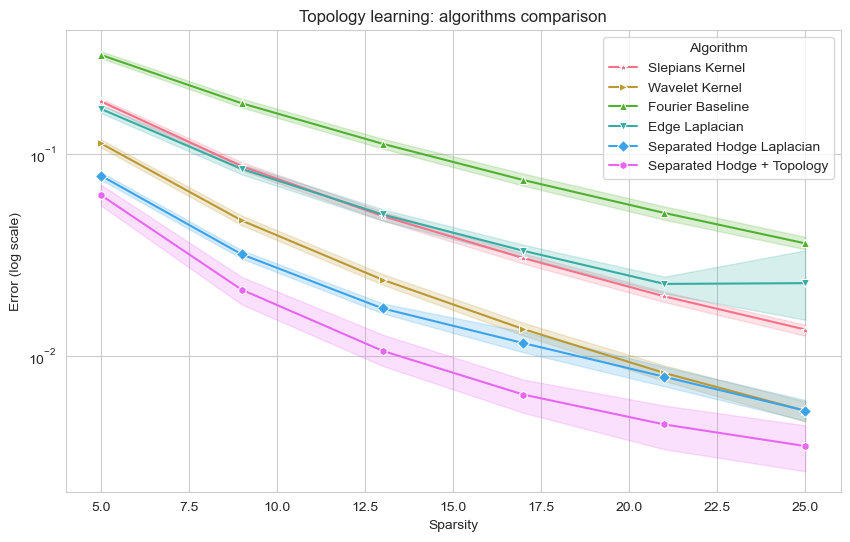

In [33]:
dict_types = {"slep": "Slepians Kernel", "wave": "Wavelet Kernel", "fou": "Fourier Baseline", "edge": "Edge Laplacian", "sep": "Separated Hodge Laplacian", "comp": "Separated Hodge + Topology"}

res_df = pd.DataFrame()
n_sim = algo_errors['slep'].shape[0]

for d in algo_errors.items():
    for sim in range(n_sim):
        tmp_df = pd.DataFrame()   
        tmp_df["Error"] = eval(f'd[1][sim,:]')
        tmp_df["Sparsity"] = K0_coll
        tmp_df["Algorithm"] = dict_types[d[0]]
        res_df = pd.concat([res_df, tmp_df])

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
my_plt = sns.lineplot(data=res_df, x='Sparsity', y='Error', hue='Algorithm',
                    palette=sns.color_palette("husl"),
                    markers=['*', '>', '^', 'v', 'D', 'h'], dashes=False, style='Algorithm')
my_plt.set(yscale='log')
my_plt.set_title(f'Topology learning: algorithms comparison')
my_plt.set_ylabel('Error (log scale)')
plt.show()

# T50

In [6]:
topo_params2 = {"J":J,
                "P":P,
                "true_prob_T":prob_T,
                "sub_size":100,
                "seed":0,
                "n":40,
                "p_edges":0.162
                }

In [7]:
from tqdm import tqdm

In [8]:
def simulate_learnable_vs_analytic(X_train, 
                                   X_test,
                                   Y_train,
                                   Y_test, 
                                   c_true, 
                                   epsilon_true, 
                                   n_sim, 
                                   topo_params, 
                                   K0_coll,
                                   max_iter,
                                   patience,
                                   tol,
                                   lambda_,
                                   step_h: int = 1,
                                   step_x: int = 1,
                                   verbose: bool = True):
    
    min_error_slep_test = np.zeros((n_sim, len(K0_coll)))
    min_error_wave_test = np.zeros((n_sim, len(K0_coll)))
    min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
    min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
    min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
    min_error_comp_test = np.zeros((n_sim, len(K0_coll)))

    algo_errors = {
        "slep": min_error_slep_test,
        "wave": min_error_wave_test,
        "fou": min_error_fou_test,
        "edge": min_error_edge_test,
        "sep": min_error_sep_test,
        "comp": min_error_comp_test
        }

    algo_types = {
        # "comp": ("separated", "Separated Hodge + Topology", True)
        "fou": ("fourier", "Fourier", False),
        "slep": ("slepians", "Slepians", False),
        "edge": ("edge_laplacian", "Edge Laplacian", False),
        "wave": ("wavelet", "Wavelets", False),
        "sep": ("separated", "Separated Hodge Laplacian", False)
        }

    for sim in range(n_sim):

        for k0_index, k0 in tqdm(enumerate(K0_coll)):

            for a in algo_types.items():

                model = TspSolver(X_train=X_train[:, :, sim], 
                                    X_test=X_test[:, :, sim], 
                                    Y_train=Y_train[:, :, sim], 
                                    Y_test=Y_test[:, :, sim],
                                    c=c_true[sim],
                                    epsilon=epsilon_true[sim],
                                    K0=k0,
                                    dictionary_type=a[1][0],
                                    **topo_params)
                
                try:
                    if a[1][2]:
                        algo_errors[a[0]][sim,k0_index],  _, _, _ = model.learn_upper_laplacian(lambda_=lambda_, 
                                                                                                max_iter=max_iter,
                                                                                                patience=patience, 
                                                                                                tol=tol,
                                                                                                verbose=True,
                                                                                                step_h=1,
                                                                                                step_x=1,
                                                                                                QP=True)
                    
                    else:
                        algo_errors[a[0]][sim,k0_index], _, _ = model.topological_dictionary_learn_qp(lambda_=lambda_, 
                                                                                                    max_iter=max_iter,
                                                                                                    patience=patience, 
                                                                                                    tol=tol,
                                                                                                    step_h=1,
                                                                                                    step_x=1)

                    if verbose:
                        print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} learning with {a[1][1]}... Done! Test Error: {algo_errors[a[0]][sim,k0_index]}")
                
                except:
                    print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {a[1][1]}... Diverged!')
                    # If diverged, simply interpolate
                    try:
                        algo_errors[a[0]][sim,k0_index] = algo_errors[a[0]][sim-1,k0_index]
                    except:
                        algo_errors[a[0]][sim,k0_index] = algo_errors[a[0]][sim+1,k0_index]

    return algo_errors

In [14]:
K0_coll[::-2]

array([25, 17,  9])

In [9]:
import warnings
warnings.filterwarnings("ignore")

algo_errors=simulate_learnable_vs_analytic(X_train[:,:,3:], 
                                            X_test[:,:,3:],
                                            Y_train[:,:,3:],
                                            Y_test[:,:,3:], 
                                            c_true[3:], 
                                            epsilon_true[3:], 
                                            n_sim-3, 
                                            topo_params2, 
                                            K0_coll,
                                            max_iter,
                                            patience,
                                            tol,
                                            lambda_)

0it [00:00, ?it/s]

Simulation: 1/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.31929895098200123
Simulation: 1/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.16239097808901745
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-10
Simulation: 1/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.16381473372882646
Simulation: 1/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1200006244140055


1it [00:18, 18.83s/it]

Simulation: 1/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.09962244671611585
Simulation: 1/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.1918033238399228
Simulation: 1/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.07436056737626835
Simulation: 1/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.07879501039360645
Simulation: 1/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.053383901238326315


2it [01:01, 33.03s/it]

Simulation: 1/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.043880825619825134
Simulation: 1/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.1278687691238158
Simulation: 1/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.038680986644647974
Simulation: 1/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04833171147681752
Simulation: 1/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.02790241415096826


3it [02:13, 50.66s/it]

Simulation: 1/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.021903212189319923
Simulation: 1/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.08865198538680838
Simulation: 1/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.022761298804762534
Simulation: 1/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.03507922033728256
Simulation: 1/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.016583173928708006


4it [03:31, 61.45s/it]

Simulation: 1/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.014350986717818906
Simulation: 1/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.06478414270881305
Simulation: 1/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.014552672141856222
Simulation: 1/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.020461086134083557
Simulation: 1/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.009771906713358945


5it [06:05, 94.82s/it]

Simulation: 1/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.009028336545223312
Simulation: 1/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.04764963789185847
Simulation: 1/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.009726517437494484
Simulation: 1/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.017632632139486952
Simulation: 1/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.0062319251914872975


6it [08:27, 84.57s/it] 


Simulation: 1/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.008383432301103111


0it [00:00, ?it/s]

Simulation: 2/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.27821185028648227
Simulation: 2/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.15146338621882954
Simulation: 2/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.10078672240402149
Simulation: 2/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.09189141346236777


1it [00:18, 18.11s/it]

Simulation: 2/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.07196312212557487
Simulation: 2/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.16284658252264095
Simulation: 2/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.0667483035664123
Simulation: 2/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.04928022053141437
Simulation: 2/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.038270584743593586


2it [00:59, 31.92s/it]

Simulation: 2/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.030132971419190586
Simulation: 2/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.10594908119155753
Simulation: 2/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.03599817045048901
Simulation: 2/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.037816426948287386
Simulation: 2/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.019979738062265724


3it [01:59, 44.45s/it]

Simulation: 2/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.01761063058103183
Simulation: 2/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.0733629530713265
Simulation: 2/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.02308567224997804
Simulation: 2/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.02305358479779478
Simulation: 2/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.011422891707565351


4it [03:28, 62.04s/it]

Simulation: 2/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.01322046478048787
Simulation: 2/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.05231600788743678
Simulation: 2/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.013858972650994806
Simulation: 2/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.023015677669892636
Simulation: 2/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.006808061820055972


5it [04:47, 68.18s/it]

Simulation: 2/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.009129702847538269
Simulation: 2/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.037599639226531256
Simulation: 2/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.009060178494701246
Simulation: 2/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.02134358740408971
Simulation: 2/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.0043651036588827526


6it [06:41, 66.96s/it]


Simulation: 2/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.006520257832490895


0it [00:00, ?it/s]

Simulation: 3/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3473524261873468
Simulation: 3/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.17841343516879166
Simulation: 3/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.1829410667980116
Simulation: 3/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.1306511201713539


1it [00:19, 19.74s/it]

Simulation: 3/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.10986580604421262
Simulation: 3/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.20815664178718418
Simulation: 3/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08499596941979126
Simulation: 3/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.09304812723612195
Simulation: 3/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.05898085323250222


2it [01:01, 32.77s/it]

Simulation: 3/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.052257856015757866
Simulation: 3/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.1378694845476692
Simulation: 3/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.04793175283858701
Simulation: 3/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.06823368579210108
Simulation: 3/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.03139836040375461


3it [02:07, 48.11s/it]

Simulation: 3/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.031298565372415134
Simulation: 3/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.09751765993647549
Simulation: 3/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.0295089635315121
Simulation: 3/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.057234643068816704
Simulation: 3/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.018267002536382842


4it [02:57, 48.68s/it]

Simulation: 3/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.019532489742713842
Simulation: 3/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.07026140810992043
Simulation: 3/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.0184936181503386
Simulation: 3/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.03858593906806085
Simulation: 3/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.011088355494857982


5it [04:07, 56.48s/it]

Simulation: 3/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.01663545265430241
Simulation: 3/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.0527470144184986
Simulation: 3/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.012561321448650298
Simulation: 3/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.025135211228600286
Simulation: 3/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.007250943955299254


6it [08:24, 84.03s/it] 


Simulation: 3/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.010330604469757337


0it [00:00, ?it/s]

Simulation: 4/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3160824830147051
Simulation: 4/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.18495670434434927
Simulation: 4/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.15435654628995585
Simulation: 4/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.12086375040681252


1it [00:55, 55.99s/it]

Simulation: 4/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.0932408940498592
Simulation: 4/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.1876147200262421
Simulation: 4/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08695743597923129
Simulation: 4/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.0772025021442418
Simulation: 4/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.05202639477223268


2it [02:36, 82.37s/it]

Simulation: 4/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.0420054816655178
Simulation: 4/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.12317745882373124
Simulation: 4/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.0486352844105926
Simulation: 4/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.057534832370955594
Simulation: 4/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.0268653546465748


3it [04:52, 106.55s/it]

Simulation: 4/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.02339463081197924
Simulation: 4/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.08622883829535066
Simulation: 4/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.0267746043604988
Simulation: 4/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.03514531151956606
Simulation: 4/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.014858648604646578


4it [07:58, 138.22s/it]

Simulation: 4/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.016887222300817607
Simulation: 4/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.06338751064724098
Simulation: 4/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.017078924075309723
Simulation: 4/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.023570791235434423
Simulation: 4/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.008959775556161209


5it [13:01, 197.56s/it]

Simulation: 4/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.011288747863036942
Simulation: 4/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.04738180887518059
Simulation: 4/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.01103579266636254
Simulation: 4/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.026173928003487813
Simulation: 4/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.0056002912546895284


6it [17:28, 174.77s/it]


Simulation: 4/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.009657770600892304


0it [00:00, ?it/s]

Simulation: 5/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3529858118360695
Simulation: 5/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.18223856952869208
Simulation: 5/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.1696516230442807
Simulation: 5/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.14111069734545523


1it [01:23, 83.58s/it]

Simulation: 5/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.12261238751544834
Simulation: 5/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.2199299328099726
Simulation: 5/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.08723180249294685
Simulation: 5/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.08415877229833296
Simulation: 5/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.06375725013586189


2it [02:11, 62.89s/it]

Simulation: 5/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.054648690113954956
Simulation: 5/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.1495408202396374
Simulation: 5/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.04812797862521804
Simulation: 5/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04718731765156441
Simulation: 5/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.03296750393885985


3it [03:22, 66.46s/it]

Simulation: 5/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.02895113362312698
Simulation: 5/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.10584639686349369
Simulation: 5/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.028597811333999447
Simulation: 5/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.045843041770837346
Simulation: 5/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.018533165790781087


4it [04:28, 66.09s/it]

Simulation: 5/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.016951647259766982
Simulation: 5/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.07722467972683462
Simulation: 5/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.01890255319356863
Simulation: 5/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.028217920043173764
Simulation: 5/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.011019857594013499


5it [05:45, 70.06s/it]

Simulation: 5/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.011068827021723888
Simulation: 5/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.05729386267630723
Simulation: 5/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.01226734202789588
Simulation: 5/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.01647935665476539
Simulation: 5/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.007231644230074223


6it [07:39, 76.61s/it]


Simulation: 5/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.008230274201485659


0it [00:00, ?it/s]

Simulation: 6/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.35647853649895145
Simulation: 6/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.17617241818322305
Simulation: 6/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.17365116790440524
Simulation: 6/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.12247269614475936


1it [00:20, 20.24s/it]

Simulation: 6/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.10624299958034832
Simulation: 6/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.21327991075216143
Simulation: 6/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.07624795581282989
Simulation: 6/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.0810053444968041
Simulation: 6/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.05155385577589675


2it [01:00, 31.93s/it]

Simulation: 6/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.04605949448968977
Simulation: 6/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.1370818020248716
Simulation: 6/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.03912829811154092
Simulation: 6/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04852418606328038
Simulation: 6/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.0267574655647556


3it [01:44, 37.32s/it]

Simulation: 6/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.028812688705759343
Simulation: 6/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.09393296232350254
Simulation: 6/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.02307140335269184
Simulation: 6/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.03624761986805706
Simulation: 6/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.014912097560582847


4it [02:48, 48.14s/it]

Simulation: 6/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.017555472041934857
Simulation: 6/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.06752700418729966
Simulation: 6/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.013884310874720083
Simulation: 6/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.024624302116281832
Simulation: 6/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.008926846078214977


5it [04:30, 67.43s/it]

Simulation: 6/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.010126809920667407
Simulation: 6/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.05067068387952714
Simulation: 6/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.008798538884188412
Simulation: 6/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.015053585990906327
Simulation: 6/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.005569104084314454


6it [05:52, 58.72s/it]


Simulation: 6/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.012849562460706726


0it [00:00, ?it/s]

Simulation: 7/7 Sparsity: 5 learning with Fourier... Done! Test Error: 0.3668289772566829
Simulation: 7/7 Sparsity: 5 learning with Slepians... Done! Test Error: 0.2094887868693053
Simulation: 7/7 Sparsity: 5 learning with Edge Laplacian... Done! Test Error: 0.15916202234292004
Simulation: 7/7 Sparsity: 5 learning with Wavelets... Done! Test Error: 0.14788578113314185


1it [00:18, 18.55s/it]

Simulation: 7/7 Sparsity: 5 learning with Separated Hodge Laplacian... Done! Test Error: 0.11301476909827644
Simulation: 7/7 Sparsity: 9 learning with Fourier... Done! Test Error: 0.2225036966670272
Simulation: 7/7 Sparsity: 9 learning with Slepians... Done! Test Error: 0.10173507805741583
Simulation: 7/7 Sparsity: 9 learning with Edge Laplacian... Done! Test Error: 0.07388263577061112
Simulation: 7/7 Sparsity: 9 learning with Wavelets... Done! Test Error: 0.06541507083048101


2it [00:48, 25.38s/it]

Simulation: 7/7 Sparsity: 9 learning with Separated Hodge Laplacian... Done! Test Error: 0.05163599787212756
Simulation: 7/7 Sparsity: 13 learning with Fourier... Done! Test Error: 0.14975578689244026
Simulation: 7/7 Sparsity: 13 learning with Slepians... Done! Test Error: 0.05788900420899397
Simulation: 7/7 Sparsity: 13 learning with Edge Laplacian... Done! Test Error: 0.04046309611026411
Simulation: 7/7 Sparsity: 13 learning with Wavelets... Done! Test Error: 0.034207104435718984


3it [01:33, 34.27s/it]

Simulation: 7/7 Sparsity: 13 learning with Separated Hodge Laplacian... Done! Test Error: 0.026954176715037893
Simulation: 7/7 Sparsity: 17 learning with Fourier... Done! Test Error: 0.10212735805399897
Simulation: 7/7 Sparsity: 17 learning with Slepians... Done! Test Error: 0.036134503414740685
Simulation: 7/7 Sparsity: 17 learning with Edge Laplacian... Done! Test Error: 0.02461458511795779
Simulation: 7/7 Sparsity: 17 learning with Wavelets... Done! Test Error: 0.01938201381416333


4it [02:32, 43.84s/it]

Simulation: 7/7 Sparsity: 17 learning with Separated Hodge Laplacian... Done! Test Error: 0.018330768827759487
Simulation: 7/7 Sparsity: 21 learning with Fourier... Done! Test Error: 0.07523543768992971
Simulation: 7/7 Sparsity: 21 learning with Slepians... Done! Test Error: 0.023835143480991902
Simulation: 7/7 Sparsity: 21 learning with Edge Laplacian... Done! Test Error: 0.015265323725978587
Simulation: 7/7 Sparsity: 21 learning with Wavelets... Done! Test Error: 0.012024636196367865


5it [03:36, 51.28s/it]

Simulation: 7/7 Sparsity: 21 learning with Separated Hodge Laplacian... Done! Test Error: 0.01225820893203508
Simulation: 7/7 Sparsity: 25 learning with Fourier... Done! Test Error: 0.05647157034659938
Simulation: 7/7 Sparsity: 25 learning with Slepians... Done! Test Error: 0.016542212427590748
Simulation: 7/7 Sparsity: 25 learning with Edge Laplacian... Done! Test Error: 0.011008025054572119
Simulation: 7/7 Sparsity: 25 learning with Wavelets... Done! Test Error: 0.007703973880932711


6it [04:55, 49.17s/it]

Simulation: 7/7 Sparsity: 25 learning with Separated Hodge Laplacian... Done! Test Error: 0.007779704236876384


In [18]:
with open('C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\gsp_res\\algo_errors_T50.pkl', 'wb') as file:
    pickle.dump(algo_errors, file)

In [1]:
import warnings
warnings.filterwarnings("ignore")

algo_errors=simulate_learnable_vs_analytic(X_train[:,:,3:], 
                                            X_test[:,:,3:],
                                            Y_train[:,:,3:],
                                            Y_test[:,:,3:], 
                                            c_true[3:], 
                                            epsilon_true[3:], 
                                            n_sim-3, 
                                            topo_params2, 
                                            K0_coll,
                                            max_iter,
                                            patience,
                                            tol,
                                            lambda_)

NameError: name 'simulate_learnable_vs_analytic' is not defined

In [1]:
import pickle

with open('C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\gsp_res\\algo_errors_T50.pkl', 'rb') as file:
    algo_errors = pickle.load(file)

In [12]:
algo_errors['comp'] = tmp_data['comp']

In [14]:
algo_errors.keys()

dict_keys(['slep', 'wave', 'fou', 'edge', 'sep', 'comp'])

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

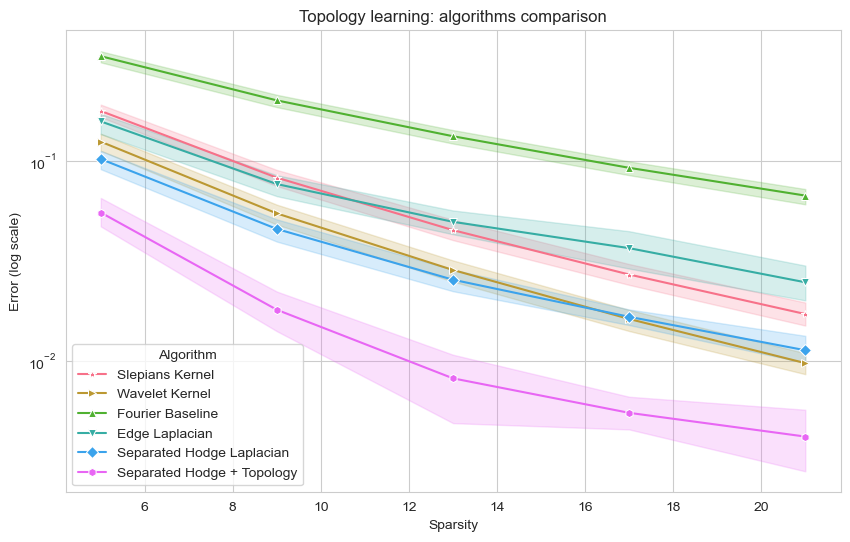

In [11]:
dict_types = {"slep": "Slepians Kernel", "wave": "Wavelet Kernel", "fou": "Fourier Baseline", "edge": "Edge Laplacian", "sep": "Separated Hodge Laplacian", "comp": "Separated Hodge + Topology"}

res_df = pd.DataFrame()
n_sim = algo_errors['slep'].shape[0]

for d in algo_errors.items():
    for sim in range(n_sim):
        tmp_df = pd.DataFrame()   
        tmp_df["Error"] = eval(f'd[1][sim,:-1]')
        tmp_df["Sparsity"] = K0_coll[:-1]
        tmp_df["Algorithm"] = dict_types[d[0]]
        res_df = pd.concat([res_df, tmp_df])

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
my_plt = sns.lineplot(data=res_df, x='Sparsity', y='Error', hue='Algorithm',
                    palette=sns.color_palette("husl"),
                    markers=['*', '>', '^', 'v', 'D', 'h'], dashes=False, style='Algorithm')
my_plt.set(yscale='log')
my_plt.set_title(f'Topology learning: algorithms comparison')
my_plt.set_ylabel('Error (log scale)')
plt.show()

# Real

In [35]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.tsp_generation import *
from tsplearn.tsp_hodgelet import * # SeparateHodgelet, SimplicianSlepians
from tsplearn.EnhancedGraph import EnhancedGraph
from typing import Tuple, List, Union, Dict
import pickle
from functools import wraps
from einops import rearrange


def _indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)

def _indicator_matrix_rev(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 1
    return np.diag(tmp)

def _compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj

def _split_coeffs(h ,s ,k, sep=False):
    h_tmp = h.value.flatten()
    # hH = h_tmp[:s,].reshape((s,1))
    # hS = h_tmp[s:s*(k+1),].reshape((s,k))
    # hI = h_tmp[s*(k+1):,].reshape((s,k))
    if sep:
        hH = h_tmp[np.arange(0, (s*(2*k+1)), (2*k+1))].reshape((s,1))
        hS = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(2*k+1)), (2*k+1))])].reshape((s,k))
        hI = h_tmp[np.hstack([[i,i+1] for i in range((k+1), (s*(2*k+1)), (2*k+1))])].reshape((s,k))
        return [hH, hS, hI]
    hi = h_tmp[np.arange(0, (s*(k+1)), (k+1))].reshape((s,1))
    h = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(k+1)), (k+1))])].reshape((s,k))
    return np.hstack([h, hi])
    
def sparse_transform(D, K0, Y_te, Y_tr=None):

    ep = np.finfo(float).eps # to avoid some underflow problems
    dd = la.norm(D, axis=0) + ep
    W = np.diag(1. / dd)
    Domp = D @ W
    X_te = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_te)
    # Normalization
    X_te = W @ X_te

    if np.all(Y_tr == None):

        return X_te
    
    # Same for the training set
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_tr)
    X_tr = W @ X_tr
    
    return X_te, X_tr


def compute_vandermonde(L, k):
    
    def polynomial_exp(x, k):
        x = x** np.arange(0, k + 1)
        return x

    eigenvalues, _ = sla.eig(L)
    idx = eigenvalues.argsort()
    tmp_df = pd.DataFrame({'Eigs': eigenvalues[idx]})
    tmp_df['Poly'] = tmp_df['Eigs'].apply(lambda x:  polynomial_exp(x,k))
    B = np.vstack(tmp_df['Poly'].to_numpy())

    return B


def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)


class TspSolver:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
                'P': None,      # Number of Kernels (Sub-dictionaries)
                'J': None,      # Polynomial order
                'K0': None,     # Sparsity level
                'dictionary_type': None,
                'c': None,      # spectral control parameter 
                'epsilon': None,# spectral control parameter
                'n': 10,        # number of nodes
                'sub_size': None,   # Number of sub-sampled nodes
                'prob_T': 1.,   # Ratio of colored triangles
                'true_prob_T': 1.,   # True ratio of colored triangles
                'p_edges': 1.,  # Probability of edge existence
                'synthetic_data': True,
                'seed': None,       ####
                'option' : "One-shot-diffusion",        ####
                'diff_order_sol' : 1,       ####
                'diff_order_irr' : 1,       ####
                'step_prog' : 1,        ####
                'top_k_slepians' : 2        ####
                }
        
        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError("When using positional arguments, must provide a single dictionary")
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data
        if params["synthetic_data"]:
            self.G = EnhancedGraph(n=params['n'],
                                p_edges=params['p_edges'], 
                                p_triangles=params['prob_T'], 
                                seed=params['seed']) 
            # Incidence matrices
            self.B1: np.ndarray = self.G.get_b1()
            self.B2: np.ndarray = self.G.get_b2()

            # Sub-sampling if needed to decrease complexity
            if params['sub_size'] != None:
                self.B1 = self.B1[:, :params['sub_size']]
                self.B2 = self.B2[:params['sub_size'], :]
                self.B2 = self.B2[:,np.sum(np.abs(self.B2), 0) == 3]
            
            # Topology dimensions and hyperparameters
            self.nu: int = self.B2.shape[1]
            self.nd: int = self.B1.shape[1]
            self.true_prob_T = params['true_prob_T']
            self.T: int = int(np.ceil(self.nu*(1-params['prob_T'])))

            # Laplacians according to the Hodge Theory for cell complexes
            Lu, Ld, L = self.G.get_laplacians(sub_size=params['sub_size'])
            self.Lu: np.ndarray = Lu                             # Ground-truth upper Laplacian
            self.Ld: np.ndarray = Ld                             # Ground-truth lower Laplacian
            self.L: np.ndarray = L                               # Ground-truth sum Laplacian
            self.Lu_full: np.ndarray = G.get_laplacians(sub_size=params['sub_size'], 
                                                        full=True)
            self.M =  L.shape[0]
        else:
            self.B1 = params['B1']
            self.B2 = params['B2']
            self.nu: int = self.B2.shape[1]
            self.nd: int = self.B1.shape[1]
            self.L, self.Lu, self.Ld = hodge_laplacians(self.B1, self.B2)
        

        # Dictionary hyperparameters
        self.P = params['P']                                 # Number of sub-dicts
        self.J = params['J']                                 # Polynomial order for the Hodge Laplacian
        self.c = params['c']                                 # Hyperparameter for stability in frequency domain
        self.epsilon = params['epsilon']                     # Hyperparameter for stability in frequency domain
        self.K0 = params['K0']                               # Assumed sparsity level
        self.dictionary_type = params['dictionary_type']
        # Init optimal values for sparse representations and overcomplete dictionary
        self.D_opt: np.ndarray = np.zeros((self.M, self.M*self.P))
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)
        # Init the learning errors and error curve (history)
        self.min_error_train = 1e20
        self.min_error_test = 1e20
        self.history: List[np.ndarray] = []

        ############################################################################################################
        ##                                                                                                        ##
        ##               This section is only for learnable (data-driven) dictionaries                            ##
        ##                                                                                                        ##
        ############################################################################################################

        # Init the dictionary parameters according to the specific parameterization setup
        if self.dictionary_type=="separated":
            hs = np.zeros((self.P,self.J))
            hi = np.zeros((self.P,self.J))
            hh = np.zeros((self.P,1))
            self.h_opt: List[np.ndarray] = [hh,hs,hi]
        else:
            h = np.zeros((self.P, self.J))
            hi = np.zeros((self.P, 1))
            self.h_opt: List[np.ndarray] = [hi, h]

        # Compute the polynomial extension for the Laplacians and the auxiliary 
        # "pseudo-vandermonde" matrix for the constraints in the quadratic form
        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.L, self.J)
            self.B = compute_vandermonde(self.L, self.J).real
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.Ld, self.J)
            self.B = compute_vandermonde(self.Ld, self.J).real
        elif  self.dictionary_type == 'separated':
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, self.J, separated=True)
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(self.Ld, self.J, separated=True)
            self.Bu = compute_vandermonde(self.Lu, self.J).real
            self.Bd = compute_vandermonde(self.Ld, self.J)[:, 1:].real
            self.B = np.hstack([self.Bu, self.Bd])

        # Auxiliary matrix to define quadratic form dor the dictionary learning step
        self.P_aux: np.ndarray = None
        # Flag variable: the dictionary is learnable or analytic
        self.dict_is_learnable = self.dictionary_type in ["separated", "joint", "edge_laplacian"]

        # Auxiliary tools for the Slepians-based dictionary setup
        if self.dictionary_type == 'slepians':
            self.option = params['option']
            self.diff_order_sol = params['diff_order_sol']
            self.step_prog = params['step_prog']
            self.diff_order_irr = params['diff_order_irr']
            self.source_sol = np.ones((self.nd,))
            self.source_irr = np.ones((self.nd,))
            self.top_K_slepians = params['top_k_slepians']
            self.spars_level = list(range(10,80,10))
            # Remember that this part should be updated if B2 or Lu are updated!
            self.F_sol,self.F_irr = get_frequency_mask(self.B1,self.B2) # Get frequency bands
            self.S_neigh, self.complete_coverage = cluster_on_neigh(self.B1,
                                                                    self.B2,
                                                                    self.diff_order_sol,
                                                                    self.diff_order_irr,
                                                                    self.source_sol,
                                                                    self.source_irr,
                                                                    self.option,
                                                                    self.step_prog)
            self.R = [self.F_sol, self.F_irr]
            self.S = self.S_neigh

        # Auxiliary tools for the Wavelet-based dictionary setup
        elif self.dictionary_type == 'wavelet':
            # Remember that this part should be updated if B2 or Lu are updated!
            self.w1 = np.linalg.eigvalsh(self.Lu)
            self.w2 = np.linalg.eigvalsh(self.Ld)
            

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, 
                                                                                    self.J, 
                                                                                    separated=True)
        self.Bu = compute_vandermonde(self.Lu, self.J).real
        self.B = np.hstack([self.Bu, self.Bd])

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, P=P, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(self,
                  h_prior: np.ndarray = None, 
                  mode: str = "only_X") -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """
        
        # If no prior info on the dictionary
        if np.all(h_prior == None):

            # Init Dictionary
            if (mode in ["all","only_D"]):

                discard = 1
                while discard==1:

                    if self.dictionary_type != "separated":
                        h_prior, discard = self._multiplier_search(self.lambda_max_j, 
                                                              self.lambda_min_j, 
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Lj)

                    else:
                        h_prior, discard = self._multiplier_search(self.lambda_max_d_j, 
                                                              self.lambda_min_d_j, 
                                                              self.lambda_max_u_j, 
                                                              self.lambda_min_u_j,
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Luj, 
                                                         self.Ldj)

            # Init Sparse Representations
            if (mode in ["all","only_X"]):
                
                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1./dd)
                Dx = Dx / la.norm(Dx)  
                Domp = Dx@W
                X = np.apply_along_axis(lambda x: get_omp_coeff(self.K0, Domp.real, x), axis=0, arr=self.Y_train)
                X = np.tile(X, (self.P,1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize both the dictionary and the sparse representation
        else:
            
            self.h_opt = h_prior

            if self.dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Luj, 
                                                 self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)
            else: 
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)             

   
    def save_results(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):

            outputs = func(self, *args, **kwargs)
            func_name = func.__name__

            if func_name == "topological_dictionary_learn":

                path = os.getcwd()
                dir_path = os.path.join(path, 
                                        'results', 
                                        'dictionary_learning',
                                        f'{self.dictionary_type}')
                name = f'learn_D_{self.dictionary_type}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": outputs[2],
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}
                
            elif func_name == "learn_upper_laplacian":

                path = os.getcwd()
                dir_path = os.path.join(path, 'results', 'topology_learning')
                name = f'learn_T{int(self.true_prob_T*100)}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": self.history,
                            "Lu_opt": self.Lu,
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}

            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            try:
                with open(filename, 'wb') as file:
                    pickle.dump(save_var, file)
            except IOError as e:
                print(f"An error occurred while writing the file: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

            return outputs  
        return wrapper

    def topological_dictionary_learn(self,
                                     lambda_: float = 1e-3, 
                                     max_iter: int = 10, 
                                     patience: int = 10,
                                     tol: float = 1e-7,
                                     step_h: float = 1.,
                                     step_x: float = 1.,
                                     solver: str ="MOSEK", 
                                     verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        if self.dict_is_learnalbe:

            # Init the dictionary and the sparse representation 
            D_coll = [cp.Constant(self.D_opt[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))
            
            while pat_iter < patience and iter_ <= max_iter:
                
                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [cp.Constant(D[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))
                
                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    hI = cp.Variable((self.P, 1))
                    h.value, hI.value = h_opt
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += (cp.Constant(self.Lj[j, :, :]) * h[i,j])
                        tmp += (I*hI[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i]for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hH.value, hS.value, hI.value = h_opt ##################### OCCHIO
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += ((cp.Constant(self.Luj[j, :, :])*hS[i,j]) + (cp.Constant(self.Ldj[j, :, :])*hI[i,j]))
                        tmp += (I*hH[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
        
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                    term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = [D_coll[i] >> 0 for i in range(self.P)] + \
                                [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)] + \
                                [(Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0, (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Dictionary Update
                D = D.value
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = [h_opt[0] + step_h*(h.value - h_opt[0]),
                             h_opt[1] + step_h*(hI.value - h_opt[1])]
                else:
                    h_opt = [h_opt[0] + step_h*(hH.value-h_opt[0]),
                             h_opt[1] + step_h*(hS.value-h_opt[1]), 
                             h_opt[2] + step_h*(hI.value-h_opt[2])]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)

            # Error Updating
            self.min_error_train = nmse(self.D_opt, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(self.D_opt, self.X_opt_test, self.Y_test, self.m_test)
            
        return self.min_error_test, self.min_error_train, hist
    

    def _aux_matrix_update(self, X):

        I = [np.eye(self.M)]
        if self.dictionary_type=="separated":
            LLu = [lu for lu in self.Luj]
            LLd = [ld for ld in self.Ldj]
            LL = np.array(I+LLu+LLd)
        else:
            LL = [l for l in self.Lj]
            LL = np.array(I + LL)

        P_aux = np.array([LL@X[(i*self.M): ((i+1)*self.M), :] for i in range(self.P)])
        self.P_aux = rearrange(P_aux, 'b h w c -> (b h) w c')
    
    def topological_dictionary_learn_qp(self,
                                        lambda_: float = 1e-3, 
                                        max_iter: int = 10, 
                                        patience: int = 10,
                                        tol: float = 1e-7,
                                        solver: str = 'GUROBI',
                                        step_h: float = 1.,
                                        step_x: float = 1.,
                                        verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        
        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        # Learnable Dictionary -> ADMM optimization algorithm
        if self.dict_is_learnable:
            
            # Init the the sparse representation
            h_opt = np.hstack([h.flatten() for h in self.h_opt]).reshape(-1,1)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            f = 2 if self.dictionary_type == "separated" else 1
            reg = lambda_ * np.eye(self.P*(f*self.J+1))
            I_s = cp.Constant(np.eye(self.P))
            i_s = cp.Constant(np.ones((self.P,1)))
            B = cp.Constant(self.B)

            while pat_iter < patience and iter_ <= max_iter:

                # Init variables and parameters
                h = cp.Variable((self.P*(f*self.J+1), 1)) 
                self._aux_matrix_update(X_tr)
                h.value = h_opt

                Q = cp.Constant(np.einsum('imn, lmn -> il', self.P_aux, self.P_aux) + reg)
                l = cp.Constant(np.einsum('mn, imn -> i', self.Y_train, self.P_aux))

                # Quadratic term
                term2 = cp.quad_form(h, Q, assume_PSD = True)
                # Linear term
                term1 = l@h
                term1 = cp.multiply(-2, term1)[0]
                
                obj = cp.Minimize(term2+term1)

                # Define the constraints
                cons1 = cp.kron(I_s, B)@h
                cons2 = cp.kron(i_s.T, B)@h
                constraints = [cons1 >= 0] + \
                                [cons1 <= self.c] + \
                                [cons2 >= (self.c - self.epsilon)] + \
                                [cons2 <= (self.c + self.epsilon)]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Update the dictionary

                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_tmp = _split_coeffs(h, self.P, self.J)
                    # print(h_tmp.shape)
                    # h_tmp = h.value.reshape(self.P, self.J+1)
                    D = generate_dictionary(h_tmp, self.P, self.Lj)                      
                    h_opt = h_opt + step_h*(h.value - h_opt)
                else:

                    h_list = _split_coeffs(h, self.P, self.J, sep=True)
                    D = generate_dictionary(h_list, self.P, self.Luj, self.Ldj)                                
                    h_opt = h_opt + step_h*(h.value - h_opt)


                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_list if self.dictionary_type == 'separated' else h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        # Analytic Dictionary -> directly go to OMP step
        else:
            
            if self.dictionary_type == "fourier":
                # Fourier Dictionary Benchmark
                _, self.D_opt = sla.eigh(self.L)

            elif self.dictionary_type == "slepians":
                SS = SimplicianSlepians(self.B1, 
                                        self.B2, 
                                        self.S, 
                                        self.R,
                                        verbose=False, 
                                        top_K = self.top_K_slepians)
                self.D_opt = SS.atoms_flat
                

            elif self.dictionary_type == "wavelet":
                SH = SeparateHodgelet(self.B1, 
                                      self.B2,
                                      *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w1))),
                                      *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w2))))
                self.D_opt = SH.atoms_flat
                # print(self.D_opt.shape)
            
            # OMP
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)
            # Error Updating
            self.min_error_train = nmse(self.D_opt, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(self.D_opt, self.X_opt_test, self.Y_test, self.m_test)

        return self.min_error_test, self.min_error_train, hist
    
    @save_results
    def learn_upper_laplacian(self,
                              Lu_new: np.ndarray = None,
                              filter: np.ndarray = 1,
                              h_prior: np.ndarray = None,
                              lambda_: float = 1e-3, 
                              max_iter: int = 10, 
                              patience: int = 10,
                              tol: float = 1e-7,
                              step_h: float = 1.,
                              step_x: float = 1.,
                              mode: str = "optimistic",
                              verbose: bool = False,
                              warmup: int = 0,
                              QP=False,
                              cont=False):
    
        assert step_h<1 or step_h>0, "You must provide a step-size between 0 and 1."
        assert step_x<1 or step_x>0, "You must provide a step-size between 0 and 1."
        assert (mode=="optimistic") or (mode=="pessimistic"), f'{mode} is not a legal mode: \"optimistic\" or \"pessimistic\" are the only ones allowed.'
        
        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = self.B2.shape[1]
            if mode=="optimistic":
                filter = np.ones(T)
                self.warmup=0  
            else:
                filter = np.zeros(T)
                self.update_Lu(np.zeros(self.Lu.shape)) # start with an "empty" upper Laplacian
                self.warmup = warmup
        else:
            self.update_Lu(Lu_new)

        self.init_dict(h_prior=h_prior,
                       mode="only_X")

        if QP:
            _, _, hist = self.topological_dictionary_learn_qp(lambda_=lambda_,
                                                            max_iter=max_iter,
                                                            patience=patience,
                                                            tol=tol,
                                                            step_h=step_h,
                                                            step_x=step_x,
                                                            solver='GUROBI')
        else:
            _, _, hist = self.topological_dictionary_learn(lambda_=lambda_,
                                                            max_iter=max_iter,
                                                            patience=patience,
                                                            tol=tol,
                                                            step_h=step_h,
                                                            step_x=step_x)
                        
        self.history.append(hist)
        search_space = np.where(filter == 1) if mode=="optimistic" else np.where(filter == 0)   
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda _: filter)
        if mode=="optimistic":
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix(x), axis=1)
        else:
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix_rev(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: _compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1)
        sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, self.K0, self.Y_test))
        sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, self.Y_test, self.m_test), axis=1)
        
        if self.warmup>0:
            candidate_error = sigmas.NMSE.min() - np.finfo(float).eps
            self.warmup-=1
        else:
            candidate_error = sigmas.NMSE.min()
        idx_min = sigmas.NMSE.idxmin()

        
        if candidate_error < self.min_error_test:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)

            if verbose:
                if mode=="optimistic":
                    print(f'Removing 1 triangle from topology... \n ... New min test error: {candidate_error} !')
                else:
                    print(f'Adding 1 triangle to topology... \n ... New min test error: {candidate_error} !')

            return self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode=mode,
                                              verbose=verbose,
                                              QP=QP,
                                              cont=cont)
        
        # For the last recursions of "pessimistic" mode try some recursion of the "optimistic"
        # to remove the warm-up randomly-added triangles
        if mode == "pessimistic" and not cont:
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="optimistic",
                                              verbose=verbose,
                                              QP=QP,
                                              cont=True)
        
        # Then after we added triangles and removed the randomly added ones, continue adding!
        elif mode != "pessimistic" and cont:

            print("Ce provo!")
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="pessimistic",
                                              verbose=verbose,
                                              QP=QP,
                                              cont=cont,
                                              warmup=warmup)  
                  
        self.B2 = self.B2@np.diag(filter)
        return self.min_error_test, self.history, self.Lu, self.B2
    
    def fit(self) -> Tuple[float, List[np.ndarray], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        min_error_test, _, _, h_opt, X_opt_test, D_opt = self.learn_upper_laplacian()
        return min_error_test, self.history, h_opt, X_opt_test, D_opt

In [ ]:
mat = scipy.io.loadmat('data_real.mat')
flow = mat["signal_edge"][:,~np.all(mat["signal_edge"] == 0, axis = 0)]
flow = flow/np.max(flow)
flow = flow[:,10:]
B1 = mat["B1"]
B2 = mat["B2"]